In [1]:
'''
cuda: 3
'''

import os
os.environ["MKL_NUM_THREADS"] = "3"
os.environ["OPENBLAS_NUM_THREADS"] = "4"
from visdom import Visdom
import numpy as np
import pandas as pd
import math
import torch
import time 
import json
import matplotlib.pyplot as plt
import torch.nn as nn
from gen_data_dl import TrainDataset, ValDataset
from torch.utils.data import DataLoader
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
from networks import TGCN
from utils import normalized_adj, Normalize
import numpy.linalg as la

In [2]:
def tgcn_loss(y_pred, y_true):
    lambda_loss = 0.0015
    Lreg = 0 # 正则化项
    for para in net.parameters():
        Lreg += torch.sum(para ** 2) / 2
    Lreg = lambda_loss * Lreg

    regress_loss = torch.sum((y_pred-y_true) ** 2) / 2
    return regress_loss + Lreg


def evaluation(a,b):
    rmse = math.sqrt(mean_squared_error(a,b))
    mae = mean_absolute_error(a,b)
    mape = mean_absolute_percentage_error(a,b)
    F_norm = la.norm(a-b,'fro')/la.norm(a,'fro')
    r2 = 1 - ((a-b)**2).sum()/((a-a.mean())**2).sum()
    var = 1-(np.var(a-b))/np.var(a)
    return rmse, mae, mape, F_norm, r2, var

In [3]:
os.environ['CUDA_VISIBLE_DEVICES']='0'
device = torch.device('cuda')
viz = Visdom()

Setting up a new session...


In [4]:
# para set
seq_len = 12
pre_len = 12
if_norm = 'sig'
inv_if_norm = 'inv_' + if_norm
src_city = 'bj'
tgt_city = 'sh'
load_batch_size = 32
epochs = 500
gru_units = 32
lr = 0.001
val_num_days = 1
yitaloss=0.9
# environ=str(pre_len*5)+'min_'+'TGCNdirTL_'+'FT:'+str(yitaloss)
environ='TGCNdirTL_'+'FT:'+str(yitaloss)+'_'+str(pre_len*5)+'min'
# load data
train_speed = TrainDataset(city='bj', typo='speed', seq_len=seq_len, pre_len=pre_len, num_days=val_num_days, if_norm=if_norm, if_lack=yitaloss)
train_loader = DataLoader(train_speed, batch_size=load_batch_size, pin_memory=True, num_workers=0, shuffle=True)
val_speed = ValDataset(city='sh', typo='speed', seq_len=seq_len, pre_len=pre_len, num_days=val_num_days, if_norm=if_norm, if_lack=yitaloss)
val_loader = DataLoader(val_speed, batch_size=val_speed.__len__(), pin_memory=True, num_workers=0, shuffle=None)
num_nodes = train_speed.numnodes
train_mean, train_std, train_max, train_min = train_speed.mean, train_speed.std, train_speed.max, train_speed.min
val_mean, val_std, val_max, val_min = val_speed.mean, val_speed.std, val_speed.max, val_speed.min

In [5]:
train_speed.__len__(), val_speed.__len__(),environ

(8904, 264, 'TGCNdirTL_FT:0.9_60min')

<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 0
Training loss: 18732.36536957115
Training rmse: 123.37961
Validation loss: 58228.171875
Validation rmse: 30.921392389803838
Validation mae: 25.538357
Validation mape: 0.27359816
Validation acc: 0.11462759971618652


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 1
Training loss: 11184.655081909617
Training rmse: 83.17629
Validation loss: 20090.87890625
Validation rmse: 18.16317034099327
Validation mae: 14.523813
Validation mape: 0.17770453
Validation acc: 0.15043383836746216


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 2
Training loss: 1971.1266241039427
Training rmse: 67.1613
Validation loss: 19862.703125
Validation rmse: 18.059732297685436
Validation mae: 14.327141
Validation mape: 0.17354947
Validation acc: 0.15765535831451416


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 3
Training loss: 1940.4945338532916
Training rmse: 66.92578
Validation loss: 19942.546875
Validation rmse: 18.095994773857246
Validation mae: 14.52323
Validation mape: 0.17939025
Validation acc: 0.16315442323684692


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 4
Training loss: 1922.3008720370603
Training rmse: 66.786156
Validation loss: 20303.580078125
Validation rmse: 18.259061053265444
Validation mae: 14.376289
Validation mape: 0.17290272
Validation acc: 0.13952523469924927


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 5
Training loss: 1912.3908063553567
Training rmse: 66.70586
Validation loss: 19698.37890625
Validation rmse: 17.984873879918162
Validation mae: 14.306362
Validation mape: 0.17516999
Validation acc: 0.1673680543899536


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 6
Training loss: 1893.3638049710182
Training rmse: 66.55774
Validation loss: 20425.83984375
Validation rmse: 18.31395228749578
Validation mae: 14.106148
Validation mape: 0.16439676
Validation acc: 0.159454345703125


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 7
Training loss: 1923.6789108877967
Training rmse: 66.78619
Validation loss: 21846.4609375
Validation rmse: 18.94012171157352
Validation mae: 14.671451
Validation mape: 0.17197055
Validation acc: 0.09311842918395996


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 8
Training loss: 1942.9021627227892
Training rmse: 66.90802
Validation loss: 24263.267578125
Validation rmse: 19.960290779640776
Validation mae: 15.775492
Validation mape: 0.19030632
Validation acc: -0.02893078327178955


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 9
Training loss: 1954.1594740344633
Training rmse: 66.98025
Validation loss: 21271.69921875
Validation rmse: 18.68930932921613
Validation mae: 14.773528
Validation mape: 0.17981838
Validation acc: 0.0991973876953125


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 10
Training loss: 1943.759266077404
Training rmse: 66.91338
Validation loss: 21600.486328125
Validation rmse: 18.8331927178909
Validation mae: 14.958374
Validation mape: 0.18404123
Validation acc: 0.09221059083938599


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 11
Training loss: 1947.8955870050684
Training rmse: 66.9467
Validation loss: 20567.740234375
Validation rmse: 18.377457019774848
Validation mae: 14.757044
Validation mape: 0.1845969
Validation acc: 0.15478497743606567


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 12
Training loss: 1926.0055275100106
Training rmse: 66.7967
Validation loss: 26762.087890625
Validation rmse: 20.962941486620725
Validation mae: 16.533
Validation mape: 0.19934326
Validation acc: -0.1349339485168457


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 13
Training loss: 1967.3992951642656
Training rmse: 66.95804
Validation loss: 23213.017578125
Validation rmse: 19.523514092987014
Validation mae: 14.903328
Validation mape: 0.17001526
Validation acc: 0.09303218126296997


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 14
Training loss: 1908.358624092567
Training rmse: 66.65286
Validation loss: 25063.013671875
Validation rmse: 20.28658051819216
Validation mae: 16.209944
Validation mape: 0.2032758
Validation acc: -0.012671947479248047


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 15
Training loss: 1891.4304893794454
Training rmse: 66.52159
Validation loss: 22778.236328125
Validation rmse: 19.339811007218294
Validation mae: 15.278726
Validation mape: 0.18524338
Validation acc: 0.034104347229003906


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 16
Training loss: 1872.895985483696
Training rmse: 66.38032
Validation loss: 19643.4296875
Validation rmse: 17.959769325049372
Validation mae: 13.791208
Validation mape: 0.1617939
Validation acc: 0.18460673093795776


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 17
Training loss: 1825.4507770059784
Training rmse: 66.01317
Validation loss: 21777.626953125
Validation rmse: 18.91025509618351
Validation mae: 14.977808
Validation mape: 0.18415204
Validation acc: 0.08409994840621948


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 18
Training loss: 1849.2425756967195
Training rmse: 66.19386
Validation loss: 20611.9453125
Validation rmse: 18.39719342927662
Validation mae: 14.261453
Validation mape: 0.16932762
Validation acc: 0.13305366039276123


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 19
Training loss: 1837.7200520833333
Training rmse: 66.10932
Validation loss: 21315.466796875
Validation rmse: 18.708522645577286
Validation mae: 14.1972685
Validation mape: 0.16199246
Validation acc: 0.1651846170425415


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 20
Training loss: 1804.2648181983648
Training rmse: 65.84125
Validation loss: 19676.505859375
Validation rmse: 17.974881766279264
Validation mae: 14.154355
Validation mape: 0.17335804
Validation acc: 0.16900873184204102


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 21
Training loss: 1786.0243039148256
Training rmse: 65.69475
Validation loss: 21167.60546875
Validation rmse: 18.643520900892923
Validation mae: 14.614338
Validation mape: 0.17647868
Validation acc: 0.10245567560195923


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 22
Training loss: 1801.469996298513
Training rmse: 65.79983
Validation loss: 22271.044921875
Validation rmse: 19.1232789705109
Validation mae: 15.513171
Validation mape: 0.19918239
Validation acc: 0.16359931230545044


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 23
Training loss: 1751.2848107122607
Training rmse: 65.415985
Validation loss: 22393.076171875
Validation rmse: 19.175598628561037
Validation mae: 14.846606
Validation mape: 0.17420754
Validation acc: 0.07422196865081787


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 24
Training loss: 1764.1049308093218
Training rmse: 65.51315
Validation loss: 18798.123046875
Validation rmse: 17.569085349265215
Validation mae: 13.712091
Validation mape: 0.1663435
Validation acc: 0.20278936624526978


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 25
Training loss: 1731.114028547827
Training rmse: 65.25365
Validation loss: 21299.85546875
Validation rmse: 18.70166703407789
Validation mae: 14.123017
Validation mape: 0.15950875
Validation acc: 0.19235825538635254


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 26
Training loss: 1711.8529094299536
Training rmse: 65.08803
Validation loss: 19511.203125
Validation rmse: 17.89921242457114
Validation mae: 13.917527
Validation mape: 0.16795266
Validation acc: 0.17267799377441406


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 27
Training loss: 1699.1718263250098
Training rmse: 64.986855
Validation loss: 20020.482421875
Validation rmse: 18.131307832874846
Validation mae: 13.749785
Validation mape: 0.15762094
Validation acc: 0.2074403166770935


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 28
Training loss: 1698.7694133362036
Training rmse: 64.98656
Validation loss: 19532.3984375
Validation rmse: 17.90892895535981
Validation mae: 14.141694
Validation mape: 0.17469318
Validation acc: 0.17921245098114014


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 29
Training loss: 1685.5249955372144
Training rmse: 64.87762
Validation loss: 18637.98828125
Validation rmse: 17.494086438071992
Validation mae: 13.798755
Validation mape: 0.17127644
Validation acc: 0.22175651788711548


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 30
Training loss: 1682.7648281521267
Training rmse: 64.85171
Validation loss: 18780.0
Validation rmse: 17.56060585315004
Validation mae: 13.369133
Validation mape: 0.1560214
Validation acc: 0.22792720794677734


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 31
Training loss: 1674.7184561999468
Training rmse: 64.78482
Validation loss: 20900.71484375
Validation rmse: 18.52559890911509
Validation mae: 14.819301
Validation mape: 0.18759769
Validation acc: 0.16573596000671387


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 32
Training loss: 1654.9238789876301
Training rmse: 64.62004
Validation loss: 18604.345703125
Validation rmse: 17.478282422632738
Validation mae: 13.721295
Validation mape: 0.16944672
Validation acc: 0.21881955862045288


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 33
Training loss: 1659.5447396445873
Training rmse: 64.65872
Validation loss: 18708.94921875
Validation rmse: 17.52734940870758
Validation mae: 13.882843
Validation mape: 0.17337158
Validation acc: 0.22371256351470947


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 34
Training loss: 1662.2788825359823
Training rmse: 64.678055
Validation loss: 19157.83203125
Validation rmse: 17.73636673149223
Validation mae: 14.100534
Validation mape: 0.17785673
Validation acc: 0.22365176677703857


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 35
Training loss: 1623.8866742315258
Training rmse: 64.3599
Validation loss: 18936.521484375
Validation rmse: 17.633621596135693
Validation mae: 13.653385
Validation mape: 0.16391926
Validation acc: 0.19856148958206177


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 36
Training loss: 1615.864205090376
Training rmse: 64.29195
Validation loss: 18069.849609375
Validation rmse: 17.225367553510015
Validation mae: 13.419787
Validation mape: 0.16384584
Validation acc: 0.23449504375457764


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 37
Training loss: 1617.6456091002324
Training rmse: 64.30496
Validation loss: 18116.078125
Validation rmse: 17.24738413561559
Validation mae: 13.538457
Validation mape: 0.16754138
Validation acc: 0.23952752351760864


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 38
Training loss: 1615.7419958627352
Training rmse: 64.29035
Validation loss: 18268.005859375
Validation rmse: 17.319550438524036
Validation mae: 13.361508
Validation mape: 0.16037606
Validation acc: 0.22688043117523193


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 39
Training loss: 1595.5386806474364
Training rmse: 64.118164
Validation loss: 18713.107421875
Validation rmse: 17.52927239291466
Validation mae: 13.604135
Validation mape: 0.16465172
Validation acc: 0.20645231008529663


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 40
Training loss: 1599.291964076326
Training rmse: 64.15014
Validation loss: 23007.009765625
Validation rmse: 19.436641956292487
Validation mae: 15.929985
Validation mape: 0.20896503
Validation acc: 0.23410844802856445


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 41
Training loss: 1591.7063761611994
Training rmse: 64.08569
Validation loss: 19657.640625
Validation rmse: 17.96620990877954
Validation mae: 14.392251
Validation mape: 0.18360111
Validation acc: 0.2287411093711853


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 42
Training loss: 1580.7561628006692
Training rmse: 63.990417
Validation loss: 17728.78125
Validation rmse: 17.061996508425256
Validation mae: 13.242003
Validation mape: 0.16128609
Validation acc: 0.24850261211395264


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 43
Training loss: 1557.0242693501134
Training rmse: 63.78732
Validation loss: 18174.94921875
Validation rmse: 17.275353417321433
Validation mae: 13.119934
Validation mape: 0.15365861
Validation acc: 0.24847793579101562


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 44
Training loss: 1563.5036922988072
Training rmse: 63.843502
Validation loss: 18047.7578125
Validation rmse: 17.214792783422396
Validation mae: 13.148081
Validation mape: 0.1550967
Validation acc: 0.24692243337631226


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 45
Training loss: 1552.0873550907259
Training rmse: 63.743233
Validation loss: 18066.2734375
Validation rmse: 17.223614401931037
Validation mae: 13.268747
Validation mape: 0.15915783
Validation acc: 0.23567265272140503


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 46
Training loss: 1548.8567571605834
Training rmse: 63.716034
Validation loss: 18323.494140625
Validation rmse: 17.34578834446609
Validation mae: 13.241097
Validation mape: 0.1564225
Validation acc: 0.2338765263557434


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 47
Training loss: 1540.7196106175795
Training rmse: 63.645023
Validation loss: 17856.248046875
Validation rmse: 17.123192907619842
Validation mae: 13.337245
Validation mape: 0.1642561
Validation acc: 0.248060941696167


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 48
Training loss: 1538.44236585829
Training rmse: 63.62308
Validation loss: 17745.900390625
Validation rmse: 17.070197189255843
Validation mae: 13.210442
Validation mape: 0.16091308
Validation acc: 0.24804216623306274


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 49
Training loss: 1529.115262595556
Training rmse: 63.543186
Validation loss: 17765.486328125
Validation rmse: 17.079608095483703
Validation mae: 13.329512
Validation mape: 0.1643919
Validation acc: 0.2527030110359192


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 50
Training loss: 1526.3436879804058
Training rmse: 63.51937
Validation loss: 18767.302734375
Validation rmse: 17.55457450175025
Validation mae: 13.264704
Validation mape: 0.153013
Validation acc: 0.24377381801605225


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 51
Training loss: 1524.7442321777344
Training rmse: 63.506912
Validation loss: 17773.767578125
Validation rmse: 17.083576976000135
Validation mae: 13.125956
Validation mape: 0.1578485
Validation acc: 0.24693942070007324


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 52
Training loss: 1519.1881003978006
Training rmse: 63.456955
Validation loss: 17728.791015625
Validation rmse: 17.06194284947726
Validation mae: 13.091015
Validation mape: 0.15681106
Validation acc: 0.25006991624832153


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 53
Training loss: 1504.036859874657
Training rmse: 63.323437
Validation loss: 17811.013671875
Validation rmse: 17.10145543022673
Validation mae: 13.057046
Validation mape: 0.1556559
Validation acc: 0.24834614992141724


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 54
Training loss: 1504.1103194041918
Training rmse: 63.32462
Validation loss: 19253.4609375
Validation rmse: 17.78047422516832
Validation mae: 13.365195
Validation mape: 0.1522983
Validation acc: 0.24668842554092407


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 55
Training loss: 1509.4278453977304
Training rmse: 63.369774
Validation loss: 18147.376953125
Validation rmse: 17.26217442895376
Validation mae: 13.160933
Validation mape: 0.15561146
Validation acc: 0.23970699310302734


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 56
Training loss: 1499.2538486056858
Training rmse: 63.281246
Validation loss: 19486.53515625
Validation rmse: 17.887763315071442
Validation mae: 13.443764
Validation mape: 0.15260822
Validation acc: 0.2467750906944275


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 57
Training loss: 1493.8675421164455
Training rmse: 63.236393
Validation loss: 17813.349609375
Validation rmse: 17.102554648013296
Validation mae: 13.303511
Validation mape: 0.16428024
Validation acc: 0.25268518924713135


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 58
Training loss: 1487.0258258559797
Training rmse: 63.175964
Validation loss: 18385.94921875
Validation rmse: 17.37525379901192
Validation mae: 13.639243
Validation mape: 0.17078716
Validation acc: 0.2455582618713379


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 59
Training loss: 1484.5820983011663
Training rmse: 63.15239
Validation loss: 17727.328125
Validation rmse: 17.061195183911227
Validation mae: 13.063663
Validation mape: 0.15647362
Validation acc: 0.24984639883041382


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 60
Training loss: 1476.8233370216944
Training rmse: 63.084545
Validation loss: 18028.5390625
Validation rmse: 17.20552588122808
Validation mae: 13.050868
Validation mape: 0.1535667
Validation acc: 0.2483418583869934


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 61
Training loss: 1477.50290835801
Training rmse: 63.086384
Validation loss: 17712.79296875
Validation rmse: 17.05418288305229
Validation mae: 13.218916
Validation mape: 0.16249923
Validation acc: 0.253745973110199


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 62
Training loss: 1471.8690290553595
Training rmse: 63.036674
Validation loss: 18519.91015625
Validation rmse: 17.438409159486763
Validation mae: 13.737417
Validation mape: 0.17345971
Validation acc: 0.25500160455703735


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 63
Training loss: 1466.1451354761705
Training rmse: 62.98733
Validation loss: 17887.365234375
Validation rmse: 17.13800490600359
Validation mae: 13.365188
Validation mape: 0.16572869
Validation acc: 0.25285106897354126


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 64
Training loss: 1463.2959251267082
Training rmse: 62.96341
Validation loss: 18068.1171875
Validation rmse: 17.224369191438296
Validation mae: 13.465401
Validation mape: 0.16819736
Validation acc: 0.2547655701637268


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 65
Training loss: 1462.0860050980764
Training rmse: 62.94988
Validation loss: 17750.84375
Validation rmse: 17.072459461668448
Validation mae: 13.246854
Validation mape: 0.16359493
Validation acc: 0.2558444142341614


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 66
Training loss: 1453.0850438490563
Training rmse: 62.869347
Validation loss: 19892.193359375
Validation rmse: 18.072921544788006
Validation mae: 14.436097
Validation mape: 0.18577011
Validation acc: 0.25655633211135864


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 67
Training loss: 1454.6495827295446
Training rmse: 62.883385
Validation loss: 17708.001953125
Validation rmse: 17.05182691166523
Validation mae: 13.019519
Validation mape: 0.15492526
Validation acc: 0.2537386417388916


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 68
Training loss: 1435.34323109179
Training rmse: 62.70916
Validation loss: 17586.990234375
Validation rmse: 16.99345720830888
Validation mae: 13.059637
Validation mape: 0.15790737
Validation acc: 0.25416481494903564


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 69
Training loss: 1435.0424433882517
Training rmse: 62.70458
Validation loss: 17691.732421875
Validation rmse: 17.043979975873263
Validation mae: 13.283167
Validation mape: 0.164827
Validation acc: 0.26205193996429443


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 70
Training loss: 1425.6099563653324
Training rmse: 62.62026
Validation loss: 17899.544921875
Validation rmse: 17.143784961115465
Validation mae: 13.007398
Validation mape: 0.15266058
Validation acc: 0.2563983201980591


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 71
Training loss: 1412.4412591312093
Training rmse: 62.502495
Validation loss: 17777.974609375
Validation rmse: 17.085459705539368
Validation mae: 12.980616
Validation mape: 0.15305988
Validation acc: 0.25714510679244995


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 72
Training loss: 1414.7700947860662
Training rmse: 62.521217
Validation loss: 17871.388671875
Validation rmse: 17.13028473999885
Validation mae: 13.399392
Validation mape: 0.16769232
Validation acc: 0.2669646739959717


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 73
Training loss: 1403.0730944124175
Training rmse: 62.418297
Validation loss: 17392.28125
Validation rmse: 16.899092140868007
Validation mae: 13.044146
Validation mape: 0.15974012
Validation acc: 0.2657387852668762


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 74
Training loss: 1395.1274767366363
Training rmse: 62.341354
Validation loss: 17338.326171875
Validation rmse: 16.872853234397887
Validation mae: 12.984244
Validation mape: 0.1578668
Validation acc: 0.2653030753135681


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 75
Training loss: 1398.0330674913193
Training rmse: 62.36905
Validation loss: 17317.90234375
Validation rmse: 16.86290618429898
Validation mae: 12.887263
Validation mape: 0.15484907
Validation acc: 0.2661970257759094


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 76
Training loss: 1395.1174954103312
Training rmse: 62.342255
Validation loss: 17326.646484375
Validation rmse: 16.867157646742918
Validation mae: 13.017556
Validation mape: 0.15873896
Validation acc: 0.26637160778045654


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 77
Training loss: 1375.5392142128346
Training rmse: 62.165882
Validation loss: 17450.4296875
Validation rmse: 16.927297073971047
Validation mae: 13.091972
Validation mape: 0.16093093
Validation acc: 0.26547133922576904


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 78
Training loss: 1368.4281430261537
Training rmse: 62.10029
Validation loss: 17450.083984375
Validation rmse: 16.92712489978871
Validation mae: 12.9186325
Validation mape: 0.15444529
Validation acc: 0.2620853781700134


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 79
Training loss: 1367.2110133017263
Training rmse: 62.08806
Validation loss: 19070.49609375
Validation rmse: 17.695630688364414
Validation mae: 14.08042
Validation mape: 0.18007618
Validation acc: 0.2698538303375244


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 80
Training loss: 1373.29006203272
Training rmse: 62.142963
Validation loss: 17573.47265625
Validation rmse: 16.986858000423812
Validation mae: 12.922153
Validation mape: 0.15312387
Validation acc: 0.26227134466171265


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 81
Training loss: 1360.7338353092098
Training rmse: 62.02526
Validation loss: 17365.595703125
Validation rmse: 16.886082153886747
Validation mae: 12.9670725
Validation mape: 0.15778434
Validation acc: 0.2644079327583313


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 82
Training loss: 1359.87450023364
Training rmse: 62.01831
Validation loss: 18884.625
Validation rmse: 17.6091687682023
Validation mae: 13.949183
Validation mape: 0.17815493
Validation acc: 0.2726617455482483


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 83
Training loss: 1358.9564587446096
Training rmse: 62.00938
Validation loss: 17660.435546875
Validation rmse: 17.028825443820068
Validation mae: 12.944349
Validation mape: 0.15308225
Validation acc: 0.2601735591888428


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 84
Training loss: 1354.9557253382966
Training rmse: 61.97361
Validation loss: 17521.822265625
Validation rmse: 16.961859609031208
Validation mae: 12.918731
Validation mape: 0.1542803
Validation acc: 0.259732186794281


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 85
Training loss: 1345.050793500784
Training rmse: 61.881023
Validation loss: 17582.033203125
Validation rmse: 16.990975172269764
Validation mae: 13.004041
Validation mape: 0.1572482
Validation acc: 0.25438690185546875


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 86
Training loss: 1341.445569985229
Training rmse: 61.848946
Validation loss: 17710.298828125
Validation rmse: 17.052839849240012
Validation mae: 12.9589405
Validation mape: 0.15376209
Validation acc: 0.2559257745742798


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 87
Training loss: 1348.9866778192554
Training rmse: 61.919186
Validation loss: 17539.505859375
Validation rmse: 16.97040629865432
Validation mae: 13.02254
Validation mape: 0.15843654
Validation acc: 0.25694042444229126


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 88
Training loss: 1335.1053086147513
Training rmse: 61.789585
Validation loss: 17699.17578125
Validation rmse: 17.047476501761924
Validation mae: 13.193024
Validation mape: 0.16306147
Validation acc: 0.2588568329811096


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 89
Training loss: 1331.988506686303
Training rmse: 61.760437
Validation loss: 17567.33984375
Validation rmse: 16.983861106531034
Validation mae: 13.055641
Validation mape: 0.15950531
Validation acc: 0.25670158863067627


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 90
Training loss: 1329.6183216819627
Training rmse: 61.7361
Validation loss: 17672.828125
Validation rmse: 17.03477332391792
Validation mae: 12.956321
Validation mape: 0.1546561
Validation acc: 0.25377607345581055


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 91
Training loss: 1326.63087359466
Training rmse: 61.706814
Validation loss: 17688.763671875
Validation rmse: 17.04245080364122
Validation mae: 12.973684
Validation mape: 0.15552002
Validation acc: 0.25124162435531616


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 92
Training loss: 1325.244887922827
Training rmse: 61.69704
Validation loss: 17800.29296875
Validation rmse: 17.096091268764386
Validation mae: 13.213505
Validation mape: 0.16300876
Validation acc: 0.25309640169143677


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 93
Training loss: 1320.5612008699807
Training rmse: 61.65451
Validation loss: 17898.921875
Validation rmse: 17.143388885243873
Validation mae: 13.273423
Validation mape: 0.16443886
Validation acc: 0.25271522998809814


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 94
Training loss: 1314.6141794949876
Training rmse: 61.59353
Validation loss: 17562.40625
Validation rmse: 16.981456741012387
Validation mae: 12.995883
Validation mape: 0.15764926
Validation acc: 0.2553114891052246


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 95
Training loss: 1312.2817545791681
Training rmse: 61.575497
Validation loss: 17935.603515625
Validation rmse: 17.160939171617418
Validation mae: 13.285469
Validation mape: 0.1646479
Validation acc: 0.2506512403488159


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 96
Training loss: 1307.0783316225989
Training rmse: 61.5226
Validation loss: 18107.0546875
Validation rmse: 17.24276625954345
Validation mae: 13.064615
Validation mape: 0.15436378
Validation acc: 0.24199259281158447


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 97
Training loss: 1302.2418705109626
Training rmse: 61.47987
Validation loss: 18232.619140625
Validation rmse: 17.302445890366556
Validation mae: 13.36979
Validation mape: 0.16548435
Validation acc: 0.2383739948272705


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 98
Training loss: 1301.9356906029486
Training rmse: 61.474506
Validation loss: 17721.91015625
Validation rmse: 17.058383990151842
Validation mae: 13.1015415
Validation mape: 0.16065794
Validation acc: 0.25140923261642456


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 99
Training loss: 1293.164596502926
Training rmse: 61.390022
Validation loss: 18207.412109375
Validation rmse: 17.290474552594162
Validation mae: 13.384443
Validation mape: 0.16693592
Validation acc: 0.24684256315231323


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 100
Training loss: 1296.2832767390862
Training rmse: 61.419838
Validation loss: 18105.982421875
Validation rmse: 17.242240598015204
Validation mae: 13.075286
Validation mape: 0.15556854
Validation acc: 0.23755013942718506


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 101
Training loss: 1291.3258047890065
Training rmse: 61.37599
Validation loss: 17942.986328125
Validation rmse: 17.16444832008336
Validation mae: 13.178685
Validation mape: 0.16225642
Validation acc: 0.24485409259796143


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 102
Training loss: 1287.7839491102432
Training rmse: 61.34321
Validation loss: 18081.3828125
Validation rmse: 17.230517899074087
Validation mae: 13.165574
Validation mape: 0.16077729
Validation acc: 0.23509705066680908


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 103
Training loss: 1292.0683307169159
Training rmse: 61.380222
Validation loss: 18039.251953125
Validation rmse: 17.210425051948892
Validation mae: 13.055663
Validation mape: 0.15591848
Validation acc: 0.2386915683746338


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 104
Training loss: 1280.6368290070563
Training rmse: 61.273464
Validation loss: 18033.818359375
Validation rmse: 17.207831547081533
Validation mae: 13.164243
Validation mape: 0.16100952
Validation acc: 0.2373531460762024


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 105
Training loss: 1279.6546839778996
Training rmse: 61.263996
Validation loss: 17870.720703125
Validation rmse: 17.129833124152963
Validation mae: 13.109048
Validation mape: 0.16067554
Validation acc: 0.24467504024505615


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 106
Training loss: 1277.3997539123754
Training rmse: 61.240536
Validation loss: 18428.970703125
Validation rmse: 17.395337832888227
Validation mae: 13.436205
Validation mape: 0.16823278
Validation acc: 0.2421538233757019


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 107
Training loss: 1275.5084006470165
Training rmse: 61.22148
Validation loss: 18323.015625
Validation rmse: 17.345254368878358
Validation mae: 13.355952
Validation mape: 0.1661678
Validation acc: 0.23893409967422485


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 108
Training loss: 1271.1275244271883
Training rmse: 61.18167
Validation loss: 18027.4921875
Validation rmse: 17.204799532488746
Validation mae: 13.181635
Validation mape: 0.16186346
Validation acc: 0.2386418581008911


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 109
Training loss: 1267.4675498606912
Training rmse: 61.14778
Validation loss: 17938.455078125
Validation rmse: 17.16225507523933
Validation mae: 13.193429
Validation mape: 0.16231586
Validation acc: 0.24277722835540771


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 110
Training loss: 1261.9901932473679
Training rmse: 61.09144
Validation loss: 18436.595703125
Validation rmse: 17.398923362659183
Validation mae: 13.374512
Validation mape: 0.16536987
Validation acc: 0.2269437313079834


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 111
Training loss: 1268.0505137016269
Training rmse: 61.147846
Validation loss: 18081.69140625
Validation rmse: 17.23063479360598
Validation mae: 13.117243
Validation mape: 0.15977511
Validation acc: 0.23384571075439453


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 112
Training loss: 1259.3306593809505
Training rmse: 61.067562
Validation loss: 18323.634765625
Validation rmse: 17.345530595534544
Validation mae: 13.155759
Validation mape: 0.15668221
Validation acc: 0.2288665771484375


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 113
Training loss: 1266.3889739880851
Training rmse: 61.133015
Validation loss: 18464.2109375
Validation rmse: 17.41194013255523
Validation mae: 13.399736
Validation mape: 0.16726847
Validation acc: 0.23591870069503784


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 114
Training loss: 1253.9669087727864
Training rmse: 61.015835
Validation loss: 18287.4609375
Validation rmse: 17.328392694054894
Validation mae: 13.292594
Validation mape: 0.16395085
Validation acc: 0.2305302619934082


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 115
Training loss: 1251.5914597596745
Training rmse: 60.99051
Validation loss: 18304.109375
Validation rmse: 17.336277247121497
Validation mae: 13.304663
Validation mape: 0.16507061
Validation acc: 0.2346867322921753


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 116
Training loss: 1247.7952949770036
Training rmse: 60.953384
Validation loss: 18134.521484375
Validation rmse: 17.255772606070753
Validation mae: 13.143646
Validation mape: 0.15929504
Validation acc: 0.23096078634262085


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 117
Training loss: 1252.9600679130965
Training rmse: 61.006683
Validation loss: 18437.5
Validation rmse: 17.39932765319405
Validation mae: 13.3668375
Validation mape: 0.16589506
Validation acc: 0.23066222667694092


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 118
Training loss: 1243.7197915354084
Training rmse: 60.913532
Validation loss: 18969.423828125
Validation rmse: 17.648537792986385
Validation mae: 13.683464
Validation mape: 0.17268983
Validation acc: 0.2334008812904358


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 119
Training loss: 1238.2356355181732
Training rmse: 60.862995
Validation loss: 18678.40625
Validation rmse: 17.51262797731611
Validation mae: 13.472893
Validation mape: 0.1677528
Validation acc: 0.22399652004241943


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 120
Training loss: 1237.7523166013875
Training rmse: 60.85857
Validation loss: 18220.904296875
Validation rmse: 17.296811483623216
Validation mae: 13.216818
Validation mape: 0.16190803
Validation acc: 0.2289002537727356


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 121
Training loss: 1232.1343868351325
Training rmse: 60.803318
Validation loss: 18168.72265625
Validation rmse: 17.272018753925018
Validation mae: 13.185269
Validation mape: 0.1618504
Validation acc: 0.23194849491119385


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 122
Training loss: 1227.4504794869372
Training rmse: 60.759495
Validation loss: 18307.341796875
Validation rmse: 17.337784904663877
Validation mae: 13.228079
Validation mape: 0.16198401
Validation acc: 0.22549891471862793


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 123
Training loss: 1221.9845710125448
Training rmse: 60.70512
Validation loss: 18457.44921875
Validation rmse: 17.40871840666337
Validation mae: 13.307064
Validation mape: 0.1647289
Validation acc: 0.22613835334777832


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 124
Training loss: 1224.8198971765444
Training rmse: 60.73286
Validation loss: 18628.068359375
Validation rmse: 17.488994516530067
Validation mae: 13.364502
Validation mape: 0.16442852
Validation acc: 0.21438384056091309


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 125
Training loss: 1220.41695882599
Training rmse: 60.68874
Validation loss: 18636.345703125
Validation rmse: 17.492878363980903
Validation mae: 13.243207
Validation mape: 0.15674643
Validation acc: 0.22102195024490356


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 126
Training loss: 1215.6924618956864
Training rmse: 60.641983
Validation loss: 18543.318359375
Validation rmse: 17.449155350931388
Validation mae: 13.376368
Validation mape: 0.16509417
Validation acc: 0.22011590003967285


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 127
Training loss: 1207.2703903362315
Training rmse: 60.56239
Validation loss: 18363.509765625
Validation rmse: 17.364343242972527
Validation mae: 13.274432
Validation mape: 0.16389334
Validation acc: 0.22779732942581177


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 128
Training loss: 1203.6891136032707
Training rmse: 60.52519
Validation loss: 18590.052734375
Validation rmse: 17.471126606277515
Validation mae: 13.365569
Validation mape: 0.16524068
Validation acc: 0.21969634294509888


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 129
Training loss: 1200.6469917981
Training rmse: 60.495052
Validation loss: 18680.177734375
Validation rmse: 17.51342258677969
Validation mae: 13.317024
Validation mape: 0.161955
Validation acc: 0.208179771900177


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 130
Training loss: 1196.5902548075576
Training rmse: 60.455063
Validation loss: 18544.75390625
Validation rmse: 17.449817313300965
Validation mae: 13.2700205
Validation mape: 0.16181326
Validation acc: 0.21429717540740967


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 131
Training loss: 1192.251215124643
Training rmse: 60.41119
Validation loss: 19484.908203125
Validation rmse: 17.88669273106319
Validation mae: 13.814029
Validation mape: 0.174756
Validation acc: 0.2207123041152954


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 132
Training loss: 1187.564211718925
Training rmse: 60.36741
Validation loss: 18655.380859375
Validation rmse: 17.50178300766141
Validation mae: 13.31737
Validation mape: 0.16067596
Validation acc: 0.20971614122390747


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 133
Training loss: 1178.5491848197034
Training rmse: 60.274418
Validation loss: 18556.529296875
Validation rmse: 17.455347259485237
Validation mae: 13.327307
Validation mape: 0.16282585
Validation acc: 0.21365827322006226


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 134
Training loss: 1172.1204560529375
Training rmse: 60.211563
Validation loss: 19624.748046875
Validation rmse: 17.950754405880392
Validation mae: 13.778997
Validation mape: 0.16078286
Validation acc: 0.21204286813735962


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 135
Training loss: 1174.68601874895
Training rmse: 60.234413
Validation loss: 18615.802734375
Validation rmse: 17.483195056253305
Validation mae: 13.314719
Validation mape: 0.1619437
Validation acc: 0.2105720043182373


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 136
Training loss: 1162.187226873145
Training rmse: 60.112522
Validation loss: 18664.408203125
Validation rmse: 17.506003085883673
Validation mae: 13.362275
Validation mape: 0.16255604
Validation acc: 0.20849579572677612


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 137
Training loss: 1151.951134028828
Training rmse: 60.00871
Validation loss: 19184.005859375
Validation rmse: 17.748016676442063
Validation mae: 13.422868
Validation mape: 0.15964298
Validation acc: 0.1954936981201172


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 138
Training loss: 1151.7693909128934
Training rmse: 60.006172
Validation loss: 19409.212890625
Validation rmse: 17.851890724553694
Validation mae: 13.640312
Validation mape: 0.16793224
Validation acc: 0.18193280696868896


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 139
Training loss: 1142.2748686540938
Training rmse: 59.91401
Validation loss: 19133.36328125
Validation rmse: 17.72456880591087
Validation mae: 13.4635935
Validation mape: 0.16414852
Validation acc: 0.1891270875930786


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 140
Training loss: 1142.99755257774
Training rmse: 59.9176
Validation loss: 19206.03515625
Validation rmse: 17.758195731126516
Validation mae: 13.529336
Validation mape: 0.1663967
Validation acc: 0.1898735761642456


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 141
Training loss: 1134.3926704434084
Training rmse: 59.83169
Validation loss: 19617.76171875
Validation rmse: 17.94754098184266
Validation mae: 13.702571
Validation mape: 0.16872074
Validation acc: 0.17331910133361816


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 142
Training loss: 1133.2381238493012
Training rmse: 59.82241
Validation loss: 19359.927734375
Validation rmse: 17.829201668299852
Validation mae: 13.594885
Validation mape: 0.16819532
Validation acc: 0.18899452686309814


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 143
Training loss: 1126.3907945421006
Training rmse: 59.74973
Validation loss: 20190.560546875
Validation rmse: 18.207682000680116
Validation mae: 14.01861
Validation mape: 0.17601612
Validation acc: 0.17766690254211426


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 144
Training loss: 1127.1809438616572
Training rmse: 59.760155
Validation loss: 19360.73828125
Validation rmse: 17.829567104525157
Validation mae: 13.481717
Validation mape: 0.16186109
Validation acc: 0.18094462156295776


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 145
Training loss: 1117.2676936323924
Training rmse: 59.654522
Validation loss: 19499.708984375
Validation rmse: 17.893445294897358
Validation mae: 13.5224905
Validation mape: 0.16309242
Validation acc: 0.1735793948173523


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 146
Training loss: 1109.7624754546791
Training rmse: 59.579727
Validation loss: 20018.5
Validation rmse: 18.12992507843343
Validation mae: 13.689613
Validation mape: 0.16605452
Validation acc: 0.151103675365448


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 147
Training loss: 1112.6451930111027
Training rmse: 59.61208
Validation loss: 20745.427734375
Validation rmse: 18.45617681554022
Validation mae: 14.221331
Validation mape: 0.17961597
Validation acc: 0.16803133487701416


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 148
Training loss: 1106.3438175980764
Training rmse: 59.546608
Validation loss: 20367.39453125
Validation rmse: 18.28723526487294
Validation mae: 13.971703
Validation mape: 0.17393596
Validation acc: 0.15639430284500122


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 149
Training loss: 1107.0156456731982
Training rmse: 59.549667
Validation loss: 19751.17578125
Validation rmse: 18.00845053777488
Validation mae: 13.603772
Validation mape: 0.16564472
Validation acc: 0.16303473711013794


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 150
Training loss: 1095.8128983692457
Training rmse: 59.436527
Validation loss: 20130.2734375
Validation rmse: 18.180463865298428
Validation mae: 13.762036
Validation mape: 0.16890852
Validation acc: 0.15062224864959717


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 151
Training loss: 1092.6911317011788
Training rmse: 59.405235
Validation loss: 20326.69921875
Validation rmse: 18.268949521019607
Validation mae: 13.838921
Validation mape: 0.17090206
Validation acc: 0.14794594049453735


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 152
Training loss: 1091.4008248715418
Training rmse: 59.38994
Validation loss: 20330.09375
Validation rmse: 18.270472083295616
Validation mae: 13.918506
Validation mape: 0.1729067
Validation acc: 0.15565872192382812


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 153
Training loss: 1085.922852546938
Training rmse: 59.333694
Validation loss: 20393.810546875
Validation rmse: 18.299079013016183
Validation mae: 13.829812
Validation mape: 0.16994767
Validation acc: 0.14178681373596191


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 154
Training loss: 1085.2420537258135
Training rmse: 59.32826
Validation loss: 20473.8359375
Validation rmse: 18.334949676469577
Validation mae: 13.785713
Validation mape: 0.16804312
Validation acc: 0.1331578493118286


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 155
Training loss: 1080.6551732435876
Training rmse: 59.27681
Validation loss: 20273.341796875
Validation rmse: 18.244945923674656
Validation mae: 13.886145
Validation mape: 0.1725177
Validation acc: 0.15912401676177979


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 156
Training loss: 1079.3439182295167
Training rmse: 59.263294
Validation loss: 20307.6328125
Validation rmse: 18.260367179262424
Validation mae: 13.674983
Validation mape: 0.16495094
Validation acc: 0.13897019624710083


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 157
Training loss: 1073.89062554691
Training rmse: 59.20676
Validation loss: 20711.78515625
Validation rmse: 18.441185741241497
Validation mae: 13.961333
Validation mape: 0.17268394
Validation acc: 0.13546442985534668


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 158
Training loss: 1072.6604583630851
Training rmse: 59.196182
Validation loss: 20645.79296875
Validation rmse: 18.41178108878465
Validation mae: 13.835666
Validation mape: 0.16899812
Validation acc: 0.12668758630752563


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 159
Training loss: 1067.790506342406
Training rmse: 59.14699
Validation loss: 20645.40234375
Validation rmse: 18.411603735134246
Validation mae: 13.8507595
Validation mape: 0.1699673
Validation acc: 0.13065695762634277


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 160
Training loss: 1065.7933621970556
Training rmse: 59.12313
Validation loss: 20695.52734375
Validation rmse: 18.433942652054085
Validation mae: 13.911435
Validation mape: 0.17162052
Validation acc: 0.131913959980011


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 161
Training loss: 1065.2669162545153
Training rmse: 59.118217
Validation loss: 21416.58984375
Validation rmse: 18.75234034873214
Validation mae: 14.288129
Validation mape: 0.17955148
Validation acc: 0.13342779874801636


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 162
Training loss: 1066.1666179916765
Training rmse: 59.12837
Validation loss: 20636.81640625
Validation rmse: 18.407769495058414
Validation mae: 13.703762
Validation mape: 0.16377002
Validation acc: 0.12803393602371216


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 163
Training loss: 1056.2008000855806
Training rmse: 59.022568
Validation loss: 21973.279296875
Validation rmse: 18.994506041632803
Validation mae: 14.493328
Validation mape: 0.18231644
Validation acc: 0.11436069011688232


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 164
Training loss: 1056.1829983837715
Training rmse: 59.02222
Validation loss: 21606.21484375
Validation rmse: 18.835175190660973
Validation mae: 14.239704
Validation mape: 0.17659044
Validation acc: 0.10350292921066284


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 165
Training loss: 1051.248523944595
Training rmse: 58.96731
Validation loss: 20996.31640625
Validation rmse: 18.56741586448598
Validation mae: 13.866057
Validation mape: 0.16817448
Validation acc: 0.10994887351989746


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 166
Training loss: 1050.1802058613
Training rmse: 58.96048
Validation loss: 20801.0703125
Validation rmse: 18.48087786550432
Validation mae: 13.81164
Validation mape: 0.16767272
Validation acc: 0.11854243278503418


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 167
Training loss: 1047.9164616301068
Training rmse: 58.933903
Validation loss: 20641.63671875
Validation rmse: 18.409911330722863
Validation mae: 13.761057
Validation mape: 0.16312164
Validation acc: 0.1332225203514099


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 168
Training loss: 1045.356702196128
Training rmse: 58.907127
Validation loss: 21003.73828125
Validation rmse: 18.570693753974467
Validation mae: 13.830559
Validation mape: 0.16415519
Validation acc: 0.11710673570632935


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 169
Training loss: 1044.6059679694501
Training rmse: 58.899815
Validation loss: 21389.130859375
Validation rmse: 18.740300225424953
Validation mae: 14.162566
Validation mape: 0.17643404
Validation acc: 0.11905306577682495


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 170
Training loss: 1043.359624500343
Training rmse: 58.88906
Validation loss: 21391.66796875
Validation rmse: 18.741411607272358
Validation mae: 14.091615
Validation mape: 0.17394312
Validation acc: 0.10414367914199829


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 171
Training loss: 1039.4474613640898
Training rmse: 58.842545
Validation loss: 20687.408203125
Validation rmse: 18.43030679332533
Validation mae: 13.782331
Validation mape: 0.16601884
Validation acc: 0.12323212623596191


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 172
Training loss: 1040.384295610544
Training rmse: 58.854527
Validation loss: 20775.720703125
Validation rmse: 18.469600961254383
Validation mae: 13.754663
Validation mape: 0.16387966
Validation acc: 0.12368959188461304


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 173
Training loss: 1034.3713923628611
Training rmse: 58.79297
Validation loss: 20741.19921875
Validation rmse: 18.454248715520684
Validation mae: 13.804823
Validation mape: 0.16686311
Validation acc: 0.1204538345336914


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 174
Training loss: 1031.5529239340067
Training rmse: 58.762794
Validation loss: 21728.078125
Validation rmse: 18.88820322824292
Validation mae: 14.230633
Validation mape: 0.17634353
Validation acc: 0.09575164318084717


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 175
Training loss: 1033.4149080775544
Training rmse: 58.77941
Validation loss: 21323.748046875
Validation rmse: 18.71162413928004
Validation mae: 14.028194
Validation mape: 0.17210156
Validation acc: 0.1016693115234375


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 176
Training loss: 1028.421648141731
Training rmse: 58.725834
Validation loss: 21443.861328125
Validation rmse: 18.76425076931114
Validation mae: 14.026314
Validation mape: 0.17075096
Validation acc: 0.0919722318649292


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 177
Training loss: 1029.5587131404534
Training rmse: 58.73922
Validation loss: 21220.064453125
Validation rmse: 18.666070292800818
Validation mae: 13.95348
Validation mape: 0.16877666
Validation acc: 0.10012328624725342


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 178
Training loss: 1024.9690250957312
Training rmse: 58.692886
Validation loss: 21636.130859375
Validation rmse: 18.848186925819284
Validation mae: 14.132511
Validation mape: 0.17351098
Validation acc: 0.08965486288070679


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 179
Training loss: 1021.2780267859018
Training rmse: 58.64997
Validation loss: 21052.892578125
Validation rmse: 18.592391789942013
Validation mae: 13.898006
Validation mape: 0.16795744
Validation acc: 0.10721343755722046


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 180
Training loss: 1024.260529056672
Training rmse: 58.682533
Validation loss: 22329.49609375
Validation rmse: 19.147829479585848
Validation mae: 14.260388
Validation mape: 0.17291783
Validation acc: 0.0533943772315979


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 181
Training loss: 1016.7684556967896
Training rmse: 58.607277
Validation loss: 21433.13671875
Validation rmse: 18.75954835002365
Validation mae: 14.109036
Validation mape: 0.17401175
Validation acc: 0.10231965780258179


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 182
Training loss: 1016.1729311925964
Training rmse: 58.596546
Validation loss: 21483.9765625
Validation rmse: 18.781785395602952
Validation mae: 14.089578
Validation mape: 0.1724194
Validation acc: 0.09313350915908813


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 183
Training loss: 1017.653548264589
Training rmse: 58.611855
Validation loss: 21287.15625
Validation rmse: 18.695548375288016
Validation mae: 13.969968
Validation mape: 0.16927871
Validation acc: 0.09748446941375732


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 184
Training loss: 1010.3434078531026
Training rmse: 58.535557
Validation loss: 21556.08984375
Validation rmse: 18.813278638371358
Validation mae: 13.937338
Validation mape: 0.16408764
Validation acc: 0.10108304023742676


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 185
Training loss: 1011.529046062073
Training rmse: 58.546497
Validation loss: 21585.412109375
Validation rmse: 18.82606559665639
Validation mae: 14.044541
Validation mape: 0.17040055
Validation acc: 0.08496713638305664


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 186
Training loss: 1010.5464666223013
Training rmse: 58.53459
Validation loss: 21945.15625
Validation rmse: 18.982306825360013
Validation mae: 14.194427
Validation mape: 0.1738808
Validation acc: 0.0755801796913147


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 187
Training loss: 1004.5898271786269
Training rmse: 58.468586
Validation loss: 22707.466796875
Validation rmse: 19.309202634922148
Validation mae: 14.290244
Validation mape: 0.16951293
Validation acc: 0.04591059684753418


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 188
Training loss: 1004.489508570736
Training rmse: 58.470665
Validation loss: 22184.728515625
Validation rmse: 19.08564089131989
Validation mae: 14.209159
Validation mape: 0.17168023
Validation acc: 0.0592116117477417


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 189
Training loss: 1002.5193334326522
Training rmse: 58.447227
Validation loss: 21736.123046875
Validation rmse: 18.89167180722434
Validation mae: 14.128132
Validation mape: 0.17271206
Validation acc: 0.08195942640304565


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 190
Training loss: 1002.1200751848119
Training rmse: 58.445614
Validation loss: 21681.783203125
Validation rmse: 18.868039091806065
Validation mae: 14.066268
Validation mape: 0.16969937
Validation acc: 0.08065205812454224


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 191
Training loss: 998.0302376148949
Training rmse: 58.40068
Validation loss: 21564.314453125
Validation rmse: 18.816852661691243
Validation mae: 14.015511
Validation mape: 0.16779633
Validation acc: 0.08803761005401611


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 192
Training loss: 998.9247596768068
Training rmse: 58.408722
Validation loss: 23030.3203125
Validation rmse: 19.445985763254264
Validation mae: 14.692737
Validation mape: 0.18325704
Validation acc: 0.05451089143753052


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 193
Training loss: 993.5212825652092
Training rmse: 58.352165
Validation loss: 22286.82421875
Validation rmse: 19.12950011522003
Validation mae: 14.353657
Validation mape: 0.17667475
Validation acc: 0.06484490633010864


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 194
Training loss: 994.7250378242958
Training rmse: 58.36777
Validation loss: 22591.755859375
Validation rmse: 19.259928731340832
Validation mae: 14.460836
Validation mape: 0.17900081
Validation acc: 0.060717642307281494


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 195
Training loss: 990.2252931765757
Training rmse: 58.315872
Validation loss: 22154.267578125
Validation rmse: 19.07251913954014
Validation mae: 14.164053
Validation mape: 0.16910864
Validation acc: 0.06455224752426147


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 196
Training loss: 988.1661650955036
Training rmse: 58.29346
Validation loss: 22170.279296875
Validation rmse: 19.07940864462302
Validation mae: 14.283779
Validation mape: 0.1749371
Validation acc: 0.06516468524932861


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 197
Training loss: 989.3442928628682
Training rmse: 58.307953
Validation loss: 22782.240234375
Validation rmse: 19.340951054571036
Validation mae: 14.396026
Validation mape: 0.17351845
Validation acc: 0.034077227115631104


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 198
Training loss: 980.902842641304
Training rmse: 58.214417
Validation loss: 22263.6328125
Validation rmse: 19.119534777484045
Validation mae: 14.264805
Validation mape: 0.17062694
Validation acc: 0.060377657413482666


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 199
Training loss: 974.9563744110873
Training rmse: 58.149414
Validation loss: 21844.53125
Validation rmse: 18.93870857839012
Validation mae: 14.166616
Validation mape: 0.17161831
Validation acc: 0.07381600141525269


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 200
Training loss: 980.1355630197833
Training rmse: 58.20751
Validation loss: 23376.45703125
Validation rmse: 19.591567019792357
Validation mae: 14.808167
Validation mape: 0.1844371
Validation acc: 0.03932124376296997


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 201
Training loss: 975.2572082191385
Training rmse: 58.151455
Validation loss: 23269.2890625
Validation rmse: 19.546601779165638
Validation mae: 14.523025
Validation mape: 0.17047283
Validation acc: 0.040542662143707275


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 202
Training loss: 975.0899785086245
Training rmse: 58.152424
Validation loss: 22678.62109375
Validation rmse: 19.296905838791147
Validation mae: 14.392632
Validation mape: 0.17532825
Validation acc: 0.04001057147979736


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 203
Training loss: 968.919668491596
Training rmse: 58.0818
Validation loss: 23078.712890625
Validation rmse: 19.466386042274898
Validation mae: 14.507646
Validation mape: 0.17119533
Validation acc: 0.03996264934539795


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 204
Training loss: 964.5655845177216
Training rmse: 58.035046
Validation loss: 22824.994140625
Validation rmse: 19.359080216177787
Validation mae: 14.428511
Validation mape: 0.17542844
Validation acc: 0.03300297260284424


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 205
Training loss: 967.5112679320852
Training rmse: 58.064457
Validation loss: 22981.388671875
Validation rmse: 19.425292275290705
Validation mae: 14.481087
Validation mape: 0.17638722
Validation acc: 0.027194678783416748


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 206
Training loss: 960.7307020618069
Training rmse: 57.988144
Validation loss: 24621.755859375
Validation rmse: 20.106651518906233
Validation mae: 15.424657
Validation mape: 0.19577664
Validation acc: 0.04168093204498291


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 207
Training loss: 963.1696133630677
Training rmse: 58.01952
Validation loss: 22955.525390625
Validation rmse: 19.41435409112007
Validation mae: 14.440382
Validation mape: 0.17303425
Validation acc: 0.028572380542755127


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 208
Training loss: 953.5841300718246
Training rmse: 57.916454
Validation loss: 24507.365234375
Validation rmse: 20.059885015034514
Validation mae: 14.97364
Validation mape: 0.17306805
Validation acc: 0.030284404754638672


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 209
Training loss: 953.2081134208214
Training rmse: 57.907024
Validation loss: 23762.376953125
Validation rmse: 19.752618157405504
Validation mae: 14.7656765
Validation mape: 0.1822578
Validation acc: 0.007609188556671143


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 210
Training loss: 951.6767241228439
Training rmse: 57.89286
Validation loss: 23480.767578125
Validation rmse: 19.63521625878607
Validation mae: 14.633789
Validation mape: 0.1787138
Validation acc: 0.007663726806640625


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 211
Training loss: 945.5286607092854
Training rmse: 57.82423
Validation loss: 23951.203125
Validation rmse: 19.830945979882838
Validation mae: 14.924186
Validation mape: 0.1845994
Validation acc: 0.0018453598022460938


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 212
Training loss: 941.3465248025874
Training rmse: 57.776733
Validation loss: 24295.92578125
Validation rmse: 19.973153979349693
Validation mae: 15.060239
Validation mape: 0.18793154
Validation acc: 0.004581034183502197


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 213
Training loss: 942.7924220587618
Training rmse: 57.790356
Validation loss: 23813.765625
Validation rmse: 19.773960692900523
Validation mae: 14.728707
Validation mape: 0.17936395
Validation acc: -0.008126616477966309


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 214
Training loss: 937.1581423632988
Training rmse: 57.72922
Validation loss: 24046.416015625
Validation rmse: 19.870320087037555
Validation mae: 14.723926
Validation mape: 0.17673963
Validation acc: -0.018095970153808594


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 215
Training loss: 934.0464753181703
Training rmse: 57.69891
Validation loss: 24380.390625
Validation rmse: 20.007839192436315
Validation mae: 14.87497
Validation mape: 0.17596912
Validation acc: -0.014227628707885742


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 216
Training loss: 932.6978886648745
Training rmse: 57.686337
Validation loss: 23997.76171875
Validation rmse: 19.850205796565827
Validation mae: 14.942937
Validation mape: 0.18584518
Validation acc: 0.0068618059158325195


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 217
Training loss: 930.4363907571335
Training rmse: 57.657
Validation loss: 24002.900390625
Validation rmse: 19.8523280548962
Validation mae: 14.800098
Validation mape: 0.1824693
Validation acc: -0.006136178970336914


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 218
Training loss: 929.2660636218218
Training rmse: 57.642303
Validation loss: 23585.31640625
Validation rmse: 19.678873358010744
Validation mae: 14.624368
Validation mape: 0.17539608
Validation acc: 0.00234377384185791


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 219
Training loss: 920.5520652306122
Training rmse: 57.54219
Validation loss: 23977.630859375
Validation rmse: 19.841872911958106
Validation mae: 14.748816
Validation mape: 0.1753068
Validation acc: -0.006634950637817383


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 220
Training loss: 920.5619926862819
Training rmse: 57.54242
Validation loss: 23459.259765625
Validation rmse: 19.6262058932355
Validation mae: 14.592632
Validation mape: 0.17672674
Validation acc: 0.005210220813751221


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 221
Training loss: 915.6573423980385
Training rmse: 57.486553
Validation loss: 23883.30859375
Validation rmse: 19.802802086042885
Validation mae: 14.703266
Validation mape: 0.17862962
Validation acc: -0.012214183807373047


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 222
Training loss: 909.7799993262068
Training rmse: 57.422287
Validation loss: 23949.76953125
Validation rmse: 19.830338110337717
Validation mae: 14.70639
Validation mape: 0.1764341
Validation acc: -0.012974381446838379


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 223
Training loss: 910.1726593236342
Training rmse: 57.4277
Validation loss: 23615.076171875
Validation rmse: 19.691276454516682
Validation mae: 14.63039
Validation mape: 0.17640157
Validation acc: -0.0010294914245605469


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 224
Training loss: 909.7227268560813
Training rmse: 57.422543
Validation loss: 24684.71484375
Validation rmse: 20.13231606513479
Validation mae: 15.1647
Validation mape: 0.1892183
Validation acc: -0.006209611892700195


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 225
Training loss: 904.5335674217525
Training rmse: 57.361095
Validation loss: 24581.322265625
Validation rmse: 20.09010768407707
Validation mae: 15.032479
Validation mape: 0.18652141
Validation acc: -0.020117998123168945


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 226
Training loss: 899.6543263534492
Training rmse: 57.308815
Validation loss: 23974.474609375
Validation rmse: 19.840555537659945
Validation mae: 14.725794
Validation mape: 0.17713235
Validation acc: -0.01547396183013916


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 227
Training loss: 896.766586139638
Training rmse: 57.278603
Validation loss: 23731.89453125
Validation rmse: 19.73991735439141
Validation mae: 14.651836
Validation mape: 0.17633167
Validation acc: -0.005530953407287598


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 228
Training loss: 896.2856655325941
Training rmse: 57.267296
Validation loss: 24035.126953125
Validation rmse: 19.86563523109104
Validation mae: 14.796492
Validation mape: 0.18153954
Validation acc: -0.012869000434875488


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 229
Training loss: 890.3058063684825
Training rmse: 57.200176
Validation loss: 24246.376953125
Validation rmse: 19.952751042648778
Validation mae: 14.851733
Validation mape: 0.18169907
Validation acc: -0.024538516998291016


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 230
Training loss: 893.466547757494
Training rmse: 57.23908
Validation loss: 23951.04296875
Validation rmse: 19.83085133812772
Validation mae: 14.754845
Validation mape: 0.17553836
Validation acc: -0.004867434501647949


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 231
Training loss: 886.8296294947252
Training rmse: 57.15871
Validation loss: 23781.04296875
Validation rmse: 19.760342364723687
Validation mae: 14.71301
Validation mape: 0.17999512
Validation acc: -0.004654049873352051


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 232
Training loss: 883.7494710833369
Training rmse: 57.124958
Validation loss: 23738.396484375
Validation rmse: 19.742612591881677
Validation mae: 14.688477
Validation mape: 0.17876415
Validation acc: -0.005873203277587891


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 233
Training loss: 881.8496611126862
Training rmse: 57.10492
Validation loss: 24090.388671875
Validation rmse: 19.88845389024826
Validation mae: 14.79142
Validation mape: 0.18071967
Validation acc: -0.018743157386779785


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 234
Training loss: 878.8760893353425
Training rmse: 57.06727
Validation loss: 24800.591796875
Validation rmse: 20.17950526800219
Validation mae: 15.184373
Validation mape: 0.19016904
Validation acc: -0.0066165924072265625


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 235
Training loss: 874.6101630426223
Training rmse: 57.0181
Validation loss: 24347.859375
Validation rmse: 19.994454187153686
Validation mae: 14.84947
Validation mape: 0.1775428
Validation acc: -0.027158260345458984


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 236
Training loss: 878.1200376120946
Training rmse: 57.05789
Validation loss: 23877.365234375
Validation rmse: 19.800313866179465
Validation mae: 14.74082
Validation mape: 0.17830446
Validation acc: -0.012543678283691406


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 237
Training loss: 873.5996753870372
Training rmse: 57.004833
Validation loss: 24280.224609375
Validation rmse: 19.966657693104114
Validation mae: 14.833558
Validation mape: 0.18129371
Validation acc: -0.026645541191101074


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 238
Training loss: 876.7094022689328
Training rmse: 57.04158
Validation loss: 24618.306640625
Validation rmse: 20.105196669156676
Validation mae: 15.01654
Validation mape: 0.17651567
Validation acc: -0.015419363975524902


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 239
Training loss: 867.1266185801517
Training rmse: 56.931385
Validation loss: 24511.341796875
Validation rmse: 20.06146636867126
Validation mae: 14.9092045
Validation mape: 0.18291439
Validation acc: -0.033292293548583984


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 240
Training loss: 865.4402214241711
Training rmse: 56.911266
Validation loss: 24126.509765625
Validation rmse: 19.903349229385366
Validation mae: 14.7997465
Validation mape: 0.18055737
Validation acc: -0.021224617958068848


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 241
Training loss: 861.1716690336932
Training rmse: 56.86471
Validation loss: 23807.10546875
Validation rmse: 19.771153963609063
Validation mae: 14.728912
Validation mape: 0.17654839
Validation acc: -0.006023406982421875


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 242
Training loss: 858.5259408164623
Training rmse: 56.828846
Validation loss: 25092.8203125
Validation rmse: 20.29804097762385
Validation mae: 15.182918
Validation mape: 0.18870628
Validation acc: -0.03920638561248779


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 243
Training loss: 862.2326799071391
Training rmse: 56.87134
Validation loss: 24929.82421875
Validation rmse: 20.232001700826974
Validation mae: 15.128615
Validation mape: 0.187352
Validation acc: -0.04056191444396973


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 244
Training loss: 862.2256267369862
Training rmse: 56.874477
Validation loss: 24814.458984375
Validation rmse: 20.18512950478644
Validation mae: 15.00302
Validation mape: 0.1839406
Validation acc: -0.04678773880004883


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 245
Training loss: 856.693613524078
Training rmse: 56.809013
Validation loss: 24576.275390625
Validation rmse: 20.088015104287386
Validation mae: 14.93998
Validation mape: 0.18337797
Validation acc: -0.035271286964416504


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 246
Training loss: 847.8088795104761
Training rmse: 56.705605
Validation loss: 24695.369140625
Validation rmse: 20.136631228592535
Validation mae: 14.925994
Validation mape: 0.1796496
Validation acc: -0.04639995098114014


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 247
Training loss: 851.9010118053806
Training rmse: 56.75275
Validation loss: 25066.818359375
Validation rmse: 20.28751167301728
Validation mae: 15.092005
Validation mape: 0.18558596
Validation acc: -0.053202033042907715


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 248
Training loss: 852.1599514322041
Training rmse: 56.75539
Validation loss: 24689.26171875
Validation rmse: 20.13413727694134
Validation mae: 15.021575
Validation mape: 0.18498667
Validation acc: -0.0363544225692749


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 249
Training loss: 844.8050785406516
Training rmse: 56.667603
Validation loss: 24755.68359375
Validation rmse: 20.16120185054933
Validation mae: 15.007277
Validation mape: 0.18279763
Validation acc: -0.048767805099487305


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 250
Training loss: 847.0561423899879
Training rmse: 56.694035
Validation loss: 24879.05859375
Validation rmse: 20.211379156606544
Validation mae: 15.042686
Validation mape: 0.1850319
Validation acc: -0.04692542552947998


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 251
Training loss: 843.0246754307901
Training rmse: 56.6524
Validation loss: 24617.626953125
Validation rmse: 20.104902954322718
Validation mae: 14.926067
Validation mape: 0.18179566
Validation acc: -0.04279816150665283


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 252
Training loss: 847.8151400439629
Training rmse: 56.705868
Validation loss: 24548.841796875
Validation rmse: 20.076790446892588
Validation mae: 14.988804
Validation mape: 0.1847924
Validation acc: -0.02988898754119873


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 253
Training loss: 838.3129212300837
Training rmse: 56.59576
Validation loss: 26141.8671875
Validation rmse: 20.718004676450807
Validation mae: 15.570186
Validation mape: 0.19445984
Validation acc: -0.07219874858856201


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 254
Training loss: 838.9087840528044
Training rmse: 56.600807
Validation loss: 24862.65625
Validation rmse: 20.20471175734179
Validation mae: 15.022048
Validation mape: 0.18379836
Validation acc: -0.05095946788787842


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 255
Training loss: 839.8976213462037
Training rmse: 56.61267
Validation loss: 25558.359375
Validation rmse: 20.485461778712956
Validation mae: 15.324878
Validation mape: 0.19076423
Validation acc: -0.05419433116912842


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 256
Training loss: 835.994652642144
Training rmse: 56.569736
Validation loss: 24722.462890625
Validation rmse: 20.147661990697735
Validation mae: 14.96147
Validation mape: 0.1834388
Validation acc: -0.042913079261779785


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 257
Training loss: 835.9074840477291
Training rmse: 56.563004
Validation loss: 24886.13671875
Validation rmse: 20.21424704735267
Validation mae: 15.026816
Validation mape: 0.18250947
Validation acc: -0.05508768558502197


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 258
Training loss: 831.3572166196761
Training rmse: 56.511642
Validation loss: 24893.375
Validation rmse: 20.21718623203103
Validation mae: 15.019663
Validation mape: 0.18163486
Validation acc: -0.05554080009460449


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 259
Training loss: 833.5862340892942
Training rmse: 56.53544
Validation loss: 25433.28515625
Validation rmse: 20.435266775205754
Validation mae: 15.27343
Validation mape: 0.18982457
Validation acc: -0.052745938301086426


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 260
Training loss: 828.711909195001
Training rmse: 56.48535
Validation loss: 25542.5546875
Validation rmse: 20.47911831865266
Validation mae: 15.299978
Validation mape: 0.19047962
Validation acc: -0.05617964267730713


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 261
Training loss: 827.8882089156831
Training rmse: 56.471615
Validation loss: 25888.7109375
Validation rmse: 20.617428771324153
Validation mae: 15.378582
Validation mape: 0.19185904
Validation acc: -0.06269824504852295


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 262
Training loss: 829.6888265302105
Training rmse: 56.492336
Validation loss: 24349.0234375
Validation rmse: 19.994897573007922
Validation mae: 14.892326
Validation mape: 0.17951101
Validation acc: -0.03132915496826172


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 263
Training loss: 827.1346530709216
Training rmse: 56.463425
Validation loss: 25058.2109375
Validation rmse: 20.28401097106336
Validation mae: 15.033753
Validation mape: 0.17994732
Validation acc: -0.05841207504272461


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 264
Training loss: 827.7406668167388
Training rmse: 56.469658
Validation loss: 25208.404296875
Validation rmse: 20.344710788804004
Validation mae: 15.120464
Validation mape: 0.18589893
Validation acc: -0.06027567386627197


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 265
Training loss: 823.8583746469149
Training rmse: 56.42535
Validation loss: 25103.212890625
Validation rmse: 20.302214944203133
Validation mae: 15.072834
Validation mape: 0.18448606
Validation acc: -0.06067943572998047


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 266
Training loss: 821.3542979797583
Training rmse: 56.38883
Validation loss: 26693.580078125
Validation rmse: 20.935481187653505
Validation mae: 15.713443
Validation mape: 0.19723226
Validation acc: -0.08262050151824951


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 267
Training loss: 818.8690708939747
Training rmse: 56.365845
Validation loss: 28045.466796875
Validation rmse: 21.459100189826955
Validation mae: 16.356783
Validation mape: 0.20904168
Validation acc: -0.06778430938720703


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 268
Training loss: 821.6594043034379
Training rmse: 56.397438
Validation loss: 25194.25
Validation rmse: 20.33899263931307
Validation mae: 15.105332
Validation mape: 0.18459445
Validation acc: -0.06619596481323242


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 269
Training loss: 816.9866901247304
Training rmse: 56.33998
Validation loss: 24911.599609375
Validation rmse: 20.22457532967318
Validation mae: 15.051586
Validation mape: 0.18476196
Validation acc: -0.050446271896362305


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 270
Training loss: 817.1742964987259
Training rmse: 56.342663
Validation loss: 24474.755859375
Validation rmse: 20.046447987219505
Validation mae: 15.006244
Validation mape: 0.18115528
Validation acc: -0.03715693950653076


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 271
Training loss: 817.6701754224771
Training rmse: 56.345394
Validation loss: 25247.98046875
Validation rmse: 20.36066629994545
Validation mae: 15.113386
Validation mape: 0.18290924
Validation acc: -0.07048356533050537


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 272
Training loss: 817.0038844829819
Training rmse: 56.340424
Validation loss: 25811.705078125
Validation rmse: 20.586726888328055
Validation mae: 15.309492
Validation mape: 0.1896295
Validation acc: -0.07893407344818115


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 273
Training loss: 815.5568057371297
Training rmse: 56.324135
Validation loss: 25619.181640625
Validation rmse: 20.509799754905657
Validation mae: 15.416178
Validation mape: 0.19201763
Validation acc: -0.06261956691741943


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 274
Training loss: 813.2497349127219
Training rmse: 56.295387
Validation loss: 26181.642578125
Validation rmse: 20.733734005964244
Validation mae: 15.389636
Validation mape: 0.19009896
Validation acc: -0.09599530696868896


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 275
Training loss: 810.0012954110313
Training rmse: 56.25786
Validation loss: 25445.947265625
Validation rmse: 20.4403324322626
Validation mae: 15.167136
Validation mape: 0.18480329
Validation acc: -0.07809460163116455


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 276
Training loss: 807.9770042938998
Training rmse: 56.23229
Validation loss: 26229.015625
Validation rmse: 20.75248170282706
Validation mae: 15.496762
Validation mape: 0.19414008
Validation acc: -0.07014882564544678


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 277
Training loss: 807.1709839195333
Training rmse: 56.22136
Validation loss: 25896.36328125
Validation rmse: 20.620454044467596
Validation mae: 15.416339
Validation mape: 0.1922673
Validation acc: -0.06788444519042969


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 278
Training loss: 803.4460495159191
Training rmse: 56.17878
Validation loss: 25623.044921875
Validation rmse: 20.51134195818941
Validation mae: 15.204092
Validation mape: 0.18613468
Validation acc: -0.08319449424743652


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 279
Training loss: 808.8291730983283
Training rmse: 56.24382
Validation loss: 25248.408203125
Validation rmse: 20.360829673904885
Validation mae: 15.101572
Validation mape: 0.18458986
Validation acc: -0.06783437728881836


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 280
Training loss: 804.2350559576438
Training rmse: 56.185925
Validation loss: 25329.33203125
Validation rmse: 20.393434762111173
Validation mae: 15.190142
Validation mape: 0.18130806
Validation acc: -0.06551384925842285


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 281
Training loss: 808.3594368008303
Training rmse: 56.23786
Validation loss: 25394.24609375
Validation rmse: 20.41954890037784
Validation mae: 15.179663
Validation mape: 0.1845765
Validation acc: -0.07681429386138916


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 282
Training loss: 799.8520695949541
Training rmse: 56.132153
Validation loss: 25589.990234375
Validation rmse: 20.498101867631092
Validation mae: 15.212974
Validation mape: 0.18674482
Validation acc: -0.07985246181488037


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 283
Training loss: 801.1402639847075
Training rmse: 56.151897
Validation loss: 25400.314453125
Validation rmse: 20.421986329315903
Validation mae: 15.157278
Validation mape: 0.1852346
Validation acc: -0.07525277137756348


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 284
Training loss: 802.1082923916506
Training rmse: 56.160275
Validation loss: 25324.025390625
Validation rmse: 20.391291745564683
Validation mae: 15.108796
Validation mape: 0.18337518
Validation acc: -0.07387328147888184


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 285
Training loss: 796.0630935614254
Training rmse: 56.088333
Validation loss: 26103.666015625
Validation rmse: 20.70282134211271
Validation mae: 15.474729
Validation mape: 0.19316876
Validation acc: -0.07229554653167725


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 286
Training loss: 795.3642272402309
Training rmse: 56.08073
Validation loss: 25976.953125
Validation rmse: 20.65250592486448
Validation mae: 15.399138
Validation mape: 0.191852
Validation acc: -0.07552647590637207


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 287
Training loss: 796.8828537917052
Training rmse: 56.09547
Validation loss: 25538.490234375
Validation rmse: 20.4774589356905
Validation mae: 15.224866
Validation mape: 0.18742661
Validation acc: -0.07458078861236572


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 288
Training loss: 792.7409309195789
Training rmse: 56.049168
Validation loss: 25172.357421875
Validation rmse: 20.330127567579662
Validation mae: 15.187024
Validation mape: 0.18390217
Validation acc: -0.06694209575653076


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 289
Training loss: 792.1136062786144
Training rmse: 56.043015
Validation loss: 26071.779296875
Validation rmse: 20.690166197856456
Validation mae: 15.332955
Validation mape: 0.18900448
Validation acc: -0.09547793865203857


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 290
Training loss: 792.281022157293
Training rmse: 56.042107
Validation loss: 25650.052734375
Validation rmse: 20.522133392617224
Validation mae: 15.262312
Validation mape: 0.18789497
Validation acc: -0.07797110080718994


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 291
Training loss: 790.3450337618483
Training rmse: 56.018364
Validation loss: 25738.21875
Validation rmse: 20.557373892058553
Validation mae: 15.321697
Validation mape: 0.18750854
Validation acc: -0.08974635601043701


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 292
Training loss: 793.0067530259437
Training rmse: 56.049427
Validation loss: 26244.169921875
Validation rmse: 20.758456425842308
Validation mae: 15.413972
Validation mape: 0.18649967
Validation acc: -0.11220049858093262


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 293
Training loss: 788.175510310785
Training rmse: 55.99283
Validation loss: 26138.751953125
Validation rmse: 20.716722392065833
Validation mae: 15.333033
Validation mape: 0.18811029
Validation acc: -0.10424387454986572


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 294
Training loss: 786.0554592447041
Training rmse: 55.971622
Validation loss: 26604.587890625
Validation rmse: 20.900519756078285
Validation mae: 15.602032
Validation mape: 0.19584477
Validation acc: -0.08339250087738037


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 295
Training loss: 785.2826766694318
Training rmse: 55.953426
Validation loss: 26096.375
Validation rmse: 20.699915730033027
Validation mae: 15.357303
Validation mape: 0.1887899
Validation acc: -0.10162866115570068


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 296
Training loss: 785.0971034333697
Training rmse: 55.954033
Validation loss: 26330.74609375
Validation rmse: 20.79266603727141
Validation mae: 15.494742
Validation mape: 0.19179296
Validation acc: -0.0986943244934082


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 297
Training loss: 784.1148644997655
Training rmse: 55.93992
Validation loss: 26176.939453125
Validation rmse: 20.731844761309382
Validation mae: 15.334865
Validation mape: 0.18830721
Validation acc: -0.10473597049713135


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 298
Training loss: 783.4041952591216
Training rmse: 55.933033
Validation loss: 26010.67578125
Validation rmse: 20.66589296594943
Validation mae: 15.309265
Validation mape: 0.18600567
Validation acc: -0.10302555561065674


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 299
Training loss: 782.3035806088465
Training rmse: 55.918705
Validation loss: 26205.994140625
Validation rmse: 20.743345365517225
Validation mae: 15.423071
Validation mape: 0.1919458
Validation acc: -0.08758234977722168


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 300
Training loss: 781.0096689313116
Training rmse: 55.90778
Validation loss: 26367.00390625
Validation rmse: 20.8069734767859
Validation mae: 15.558518
Validation mape: 0.19422577
Validation acc: -0.08466601371765137


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 301
Training loss: 784.0400102403429
Training rmse: 55.939716
Validation loss: 25563.2265625
Validation rmse: 20.487352889477176
Validation mae: 15.256194
Validation mape: 0.18617481
Validation acc: -0.0837090015411377


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 302
Training loss: 776.3478456449337
Training rmse: 55.843494
Validation loss: 27266.857421875
Validation rmse: 21.159065543815966
Validation mae: 15.801635
Validation mape: 0.19718304
Validation acc: -0.11899459362030029


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 303
Training loss: 779.2234441285492
Training rmse: 55.880787
Validation loss: 25997.283203125
Validation rmse: 20.66056651665347
Validation mae: 15.366699
Validation mape: 0.19027656
Validation acc: -0.08931457996368408


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 304
Training loss: 774.695547780683
Training rmse: 55.826466
Validation loss: 26336.6953125
Validation rmse: 20.795005433434312
Validation mae: 15.453982
Validation mape: 0.19167408
Validation acc: -0.09800291061401367


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 305
Training loss: 776.7881552309973
Training rmse: 55.852406
Validation loss: 25643.79296875
Validation rmse: 20.519610445663847
Validation mae: 15.259952
Validation mape: 0.18582481
Validation acc: -0.08746516704559326


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 306
Training loss: 776.7146504173143
Training rmse: 55.853115
Validation loss: 26289.5546875
Validation rmse: 20.776381302323347
Validation mae: 15.425689
Validation mape: 0.19097157
Validation acc: -0.10205185413360596


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 307
Training loss: 771.2242776193926
Training rmse: 55.786354
Validation loss: 26800.568359375
Validation rmse: 20.97734737242064
Validation mae: 15.480256
Validation mape: 0.1897657
Validation acc: -0.13261628150939941


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 308
Training loss: 771.8414137098524
Training rmse: 55.79256
Validation loss: 25582.259765625
Validation rmse: 20.494970681662064
Validation mae: 15.232401
Validation mape: 0.184833
Validation acc: -0.08480191230773926


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 309
Training loss: 772.9100023495254
Training rmse: 55.802536
Validation loss: 26331.3828125
Validation rmse: 20.792903070885373
Validation mae: 15.392735
Validation mape: 0.1891452
Validation acc: -0.1106787919998169


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 310
Training loss: 769.328391071716
Training rmse: 55.761303
Validation loss: 26615.453125
Validation rmse: 20.904767586876638
Validation mae: 15.484575
Validation mape: 0.19081791
Validation acc: -0.12139606475830078


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 311
Training loss: 771.1154347081339
Training rmse: 55.785065
Validation loss: 26312.076171875
Validation rmse: 20.785274809965376
Validation mae: 15.391393
Validation mape: 0.18920939
Validation acc: -0.11009359359741211


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 312
Training loss: 767.2031749875742
Training rmse: 55.731316
Validation loss: 26413.51171875
Validation rmse: 20.82530208153316
Validation mae: 15.395927
Validation mape: 0.18897092
Validation acc: -0.11520135402679443


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 313
Training loss: 770.8705960618979
Training rmse: 55.777172
Validation loss: 26381.23828125
Validation rmse: 20.81257331537387
Validation mae: 15.377101
Validation mape: 0.18908527
Validation acc: -0.1123267412185669


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 314
Training loss: 766.0352110503823
Training rmse: 55.721817
Validation loss: 26654.18359375
Validation rmse: 20.91996773536776
Validation mae: 15.505468
Validation mape: 0.19120845
Validation acc: -0.12189030647277832


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 315
Training loss: 764.9569431427987
Training rmse: 55.705387
Validation loss: 27380.458984375
Validation rmse: 21.203083980017432
Validation mae: 15.915056
Validation mape: 0.20050183
Validation acc: -0.10480475425720215


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 316
Training loss: 765.1880066574261
Training rmse: 55.703857
Validation loss: 26868.34765625
Validation rmse: 21.003848495247915
Validation mae: 15.672894
Validation mape: 0.19465597
Validation acc: -0.11412286758422852


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 317
Training loss: 767.7101470509738
Training rmse: 55.73724
Validation loss: 27262.25
Validation rmse: 21.157261157981466
Validation mae: 15.710667
Validation mape: 0.19592251
Validation acc: -0.1277484893798828


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 318
Training loss: 763.3828717850442
Training rmse: 55.689312
Validation loss: 26411.55859375
Validation rmse: 20.824525400457436
Validation mae: 15.397544
Validation mape: 0.18878312
Validation acc: -0.11674809455871582


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 319
Training loss: 760.7449312927903
Training rmse: 55.65133
Validation loss: 28276.080078125
Validation rmse: 21.547089573578074
Validation mae: 16.017956
Validation mape: 0.20188493
Validation acc: -0.14025795459747314


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 320
Training loss: 764.0118479301425
Training rmse: 55.699104
Validation loss: 27112.498046875
Validation rmse: 21.099063277581926
Validation mae: 15.622969
Validation mape: 0.19443022
Validation acc: -0.12477719783782959


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 321
Training loss: 762.2465154176117
Training rmse: 55.671196
Validation loss: 27375.5625
Validation rmse: 21.201182580749254
Validation mae: 15.692971
Validation mape: 0.1947401
Validation acc: -0.1394597291946411


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 322
Training loss: 759.582267624503
Training rmse: 55.64167
Validation loss: 27411.966796875
Validation rmse: 21.215274936351875
Validation mae: 15.741328
Validation mape: 0.19479989
Validation acc: -0.14668428897857666


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 323
Training loss: 759.5264225894832
Training rmse: 55.63668
Validation loss: 27544.978515625
Validation rmse: 21.26668476992866
Validation mae: 15.661796
Validation mape: 0.19298321
Validation acc: -0.1587505340576172


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 324
Training loss: 758.7688358539322
Training rmse: 55.626583
Validation loss: 26898.189453125
Validation rmse: 21.01550084187302
Validation mae: 15.545121
Validation mape: 0.18939754
Validation acc: -0.14038372039794922


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 325
Training loss: 759.7364522735705
Training rmse: 55.63863
Validation loss: 26506.87109375
Validation rmse: 20.86206384823449
Validation mae: 15.535127
Validation mape: 0.18998341
Validation acc: -0.12344062328338623


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 326
Training loss: 755.392807663128
Training rmse: 55.585873
Validation loss: 28149.724609375
Validation rmse: 21.498884305172385
Validation mae: 16.020676
Validation mape: 0.20175785
Validation acc: -0.13292241096496582


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 327
Training loss: 757.8257224790511
Training rmse: 55.61757
Validation loss: 26792.064453125
Validation rmse: 20.973996002211436
Validation mae: 15.564773
Validation mape: 0.19168226
Validation acc: -0.12806439399719238


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 328
Training loss: 759.3527698585209
Training rmse: 55.63486
Validation loss: 28786.138671875
Validation rmse: 21.740563461174943
Validation mae: 16.208563
Validation mape: 0.20515318
Validation acc: -0.14561593532562256


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 329
Training loss: 757.3875388415483
Training rmse: 55.616657
Validation loss: 28325.77734375
Validation rmse: 21.566008970598197
Validation mae: 15.991829
Validation mape: 0.2013115
Validation acc: -0.14349353313446045


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 330
Training loss: 759.2161688582444
Training rmse: 55.62906
Validation loss: 27630.181640625
Validation rmse: 21.29954515428198
Validation mae: 15.842033
Validation mape: 0.19715616
Validation acc: -0.14463400840759277


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 331
Training loss: 751.1960377026629
Training rmse: 55.535866
Validation loss: 26487.400390625
Validation rmse: 20.854392107323953
Validation mae: 15.494176
Validation mape: 0.1893515
Validation acc: -0.12244486808776855


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 332
Training loss: 750.6894205838548
Training rmse: 55.527542
Validation loss: 26973.0703125
Validation rmse: 21.044724567665558
Validation mae: 15.586196
Validation mape: 0.19180447
Validation acc: -0.13682174682617188


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 333
Training loss: 752.4543388667499
Training rmse: 55.54914
Validation loss: 26741.314453125
Validation rmse: 20.95411391915007
Validation mae: 15.518747
Validation mape: 0.19164337
Validation acc: -0.12209451198577881


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 334
Training loss: 751.8814755238085
Training rmse: 55.541546
Validation loss: 27657.51953125
Validation rmse: 21.310077786887668
Validation mae: 15.720137
Validation mape: 0.1946461
Validation acc: -0.15668880939483643


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 335
Training loss: 752.5580723260039
Training rmse: 55.551052
Validation loss: 27493.19140625
Validation rmse: 21.246668655464042
Validation mae: 15.775674
Validation mape: 0.19171475
Validation acc: -0.16587352752685547


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 336
Training loss: 749.2759814518754
Training rmse: 55.50987
Validation loss: 27570.884765625
Validation rmse: 21.276671422620876
Validation mae: 15.738547
Validation mape: 0.19462658
Validation acc: -0.15501844882965088


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 337
Training loss: 747.7935244652533
Training rmse: 55.489044
Validation loss: 28446.287109375
Validation rmse: 21.611829330072627
Validation mae: 15.927822
Validation mape: 0.19585985
Validation acc: -0.19915807247161865


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 338
Training loss: 745.8742347635249
Training rmse: 55.466946
Validation loss: 27642.70703125
Validation rmse: 21.30436591593559
Validation mae: 15.708596
Validation mape: 0.1937159
Validation acc: -0.16139066219329834


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 339
Training loss: 749.6649811447307
Training rmse: 55.515762
Validation loss: 26981.107421875
Validation rmse: 21.047854439673223
Validation mae: 15.597919
Validation mape: 0.1906617
Validation acc: -0.1426846981048584


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 340
Training loss: 746.3832764984459
Training rmse: 55.47465
Validation loss: 27728.26171875
Validation rmse: 21.33730986409318
Validation mae: 15.869441
Validation mape: 0.19755787
Validation acc: -0.14631617069244385


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 341
Training loss: 749.8035178782692
Training rmse: 55.517002
Validation loss: 26998.4453125
Validation rmse: 21.054612853531868
Validation mae: 15.563593
Validation mape: 0.18889984
Validation acc: -0.1449127197265625


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 342
Training loss: 744.1751068552762
Training rmse: 55.446198
Validation loss: 27648.80078125
Validation rmse: 21.306709285943317
Validation mae: 15.749778
Validation mape: 0.19537336
Validation acc: -0.15314412117004395


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 343
Training loss: 749.9468897337555
Training rmse: 55.51888
Validation loss: 28439.39453125
Validation rmse: 21.60920411853983
Validation mae: 15.97876
Validation mape: 0.19973624
Validation acc: -0.16722822189331055


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 344
Training loss: 743.1305764037648
Training rmse: 55.430527
Validation loss: 29214.71875
Validation rmse: 21.901801382730913
Validation mae: 16.21158
Validation mape: 0.20387034
Validation acc: -0.17827534675598145


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 345
Training loss: 743.7511774972348
Training rmse: 55.441574
Validation loss: 27561.6015625
Validation rmse: 21.273077427635794
Validation mae: 15.691921
Validation mape: 0.19212116
Validation acc: -0.1662527322769165


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 346
Training loss: 743.1220953062871
Training rmse: 55.433453
Validation loss: 28711.953125
Validation rmse: 21.7125117502307
Validation mae: 16.07474
Validation mape: 0.20071644
Validation acc: -0.1779007911682129


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 347
Training loss: 744.6961318258743
Training rmse: 55.452156
Validation loss: 28139.763671875
Validation rmse: 21.49505913317458
Validation mae: 15.902047
Validation mape: 0.19819942
Validation acc: -0.16426920890808105


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 348
Training loss: 741.4396615524018
Training rmse: 55.41121
Validation loss: 27057.865234375
Validation rmse: 21.07776448681688
Validation mae: 15.598916
Validation mape: 0.19080812
Validation acc: -0.1449422836303711


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 349
Training loss: 741.2950809164287
Training rmse: 55.4059
Validation loss: 27280.009765625
Validation rmse: 21.164116573159053
Validation mae: 15.680107
Validation mape: 0.19412716
Validation acc: -0.13958394527435303


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 350
Training loss: 738.9403846768068
Training rmse: 55.377617
Validation loss: 27758.31640625
Validation rmse: 21.34886168543119
Validation mae: 15.746169
Validation mape: 0.19509064
Validation acc: -0.1603379249572754


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 351
Training loss: 741.0739586942939
Training rmse: 55.40555
Validation loss: 27920.537109375
Validation rmse: 21.411154348086377
Validation mae: 15.802093
Validation mape: 0.19433273
Validation acc: -0.17657709121704102


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 352
Training loss: 739.8167724062465
Training rmse: 55.39001
Validation loss: 27244.212890625
Validation rmse: 21.15022315951455
Validation mae: 15.680221
Validation mape: 0.19187759
Validation acc: -0.15291595458984375


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 353
Training loss: 739.1585302318723
Training rmse: 55.385883
Validation loss: 27752.84765625
Validation rmse: 21.346755970838185
Validation mae: 15.7714815
Validation mape: 0.19486701
Validation acc: -0.1611109972000122


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 354
Training loss: 735.7999012171153
Training rmse: 55.34046
Validation loss: 28434.291015625
Validation rmse: 21.607255833137902
Validation mae: 15.926736
Validation mape: 0.19705795
Validation acc: -0.1859952211380005


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 355
Training loss: 739.5125650932284
Training rmse: 55.383812
Validation loss: 27912.6796875
Validation rmse: 21.408139600677806
Validation mae: 15.80981
Validation mape: 0.19451858
Validation acc: -0.17637181282043457


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 356
Training loss: 737.2454995869736
Training rmse: 55.358303
Validation loss: 27601.310546875
Validation rmse: 21.288391617869614
Validation mae: 15.799769
Validation mape: 0.19687912
Validation acc: -0.13993728160858154


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 357
Training loss: 736.2405782173184
Training rmse: 55.346466
Validation loss: 28371.205078125
Validation rmse: 21.583268841778448
Validation mae: 15.923535
Validation mape: 0.19819242
Validation acc: -0.17332005500793457


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 358
Training loss: 735.4625338756056
Training rmse: 55.338104
Validation loss: 28068.21484375
Validation rmse: 21.467703759077263
Validation mae: 15.948845
Validation mape: 0.19973585
Validation acc: -0.14638102054595947


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 359
Training loss: 736.8429532615087
Training rmse: 55.351612
Validation loss: 27186.189453125
Validation rmse: 21.127683209541324
Validation mae: 15.662985
Validation mape: 0.19280331
Validation acc: -0.14566433429718018


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 360
Training loss: 737.7038139425298
Training rmse: 55.365437
Validation loss: 28022.1015625
Validation rmse: 21.450057108342904
Validation mae: 15.819605
Validation mape: 0.19451
Validation acc: -0.1789473295211792


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 361
Training loss: 736.0797913253948
Training rmse: 55.343662
Validation loss: 28653.771484375
Validation rmse: 21.690485767994282
Validation mae: 16.043652
Validation mape: 0.19724137
Validation acc: -0.20625066757202148


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 362
Training loss: 734.0607020333676
Training rmse: 55.317215
Validation loss: 27184.435546875
Validation rmse: 21.12699853596511
Validation mae: 15.662234
Validation mape: 0.19357443
Validation acc: -0.13677239418029785


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 363
Training loss: 738.3476858378311
Training rmse: 55.372467
Validation loss: 28081.53515625
Validation rmse: 21.472791621708083
Validation mae: 15.813
Validation mape: 0.19449757
Validation acc: -0.18131518363952637


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 364
Training loss: 731.5350975665567
Training rmse: 55.28773
Validation loss: 27596.11328125
Validation rmse: 21.28637884461343
Validation mae: 15.734592
Validation mape: 0.19307107
Validation acc: -0.16526365280151367


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 365
Training loss: 729.1533444312311
Training rmse: 55.255787
Validation loss: 27899.009765625
Validation rmse: 21.402888079977956
Validation mae: 15.796795
Validation mape: 0.19489494
Validation acc: -0.17125391960144043


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 366
Training loss: 729.372808859767
Training rmse: 55.25873
Validation loss: 28981.57421875
Validation rmse: 21.814208217943214
Validation mae: 16.066666
Validation mape: 0.19964041
Validation acc: -0.19998741149902344


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 367
Training loss: 730.1610593624868
Training rmse: 55.268406
Validation loss: 26870.037109375
Validation rmse: 21.00445799965748
Validation mae: 15.617228
Validation mape: 0.19078241
Validation acc: -0.13865447044372559


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 368
Training loss: 730.9928601993028
Training rmse: 55.276382
Validation loss: 28179.08203125
Validation rmse: 21.510052127535555
Validation mae: 15.871169
Validation mape: 0.1962741
Validation acc: -0.1790311336517334


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 369
Training loss: 729.7298553904325
Training rmse: 55.264797
Validation loss: 27307.587890625
Validation rmse: 21.174795837499016
Validation mae: 15.65621
Validation mape: 0.1926569
Validation acc: -0.14955532550811768


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 370
Training loss: 728.3229305034897
Training rmse: 55.248516
Validation loss: 28224.5234375
Validation rmse: 21.52738450651649
Validation mae: 15.9147215
Validation mape: 0.19639601
Validation acc: -0.18281042575836182


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 371
Training loss: 730.5707004232646
Training rmse: 55.276043
Validation loss: 28423.458984375
Validation rmse: 21.60312494349414
Validation mae: 15.921008
Validation mape: 0.19749777
Validation acc: -0.18398749828338623


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 372
Training loss: 725.3867428687311
Training rmse: 55.20965
Validation loss: 27588.7734375
Validation rmse: 21.283539994724357
Validation mae: 15.734563
Validation mape: 0.19366558
Validation acc: -0.1598200798034668


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 373
Training loss: 729.0632606971221
Training rmse: 55.25741
Validation loss: 28403.220703125
Validation rmse: 21.595431713638824
Validation mae: 15.919587
Validation mape: 0.19747284
Validation acc: -0.18039798736572266


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 374
Training loss: 730.5814692452817
Training rmse: 55.27248
Validation loss: 27627.361328125
Validation rmse: 21.29841609313171
Validation mae: 15.757329
Validation mape: 0.1927068
Validation acc: -0.16766345500946045


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 375
Training loss: 725.6761547348406
Training rmse: 55.208332
Validation loss: 29643.685546875
Validation rmse: 22.06199303927989
Validation mae: 16.378935
Validation mape: 0.20613956
Validation acc: -0.19056165218353271


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 376
Training loss: 724.9033267113471
Training rmse: 55.200764
Validation loss: 28545.01953125
Validation rmse: 21.649272725001282
Validation mae: 16.00207
Validation mape: 0.19975708
Validation acc: -0.17218494415283203


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 377
Training loss: 724.8233304040833
Training rmse: 55.201553
Validation loss: 27460.1484375
Validation rmse: 21.233859765410276
Validation mae: 15.654425
Validation mape: 0.19077367
Validation acc: -0.16317570209503174


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 378
Training loss: 726.8614195136614
Training rmse: 55.2264
Validation loss: 27679.5546875
Validation rmse: 21.31852462501803
Validation mae: 15.778722
Validation mape: 0.19570866
Validation acc: -0.15410184860229492


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 379
Training loss: 727.5439570163741
Training rmse: 55.238243
Validation loss: 27495.345703125
Validation rmse: 21.24746150393802
Validation mae: 15.705574
Validation mape: 0.19350308
Validation acc: -0.15448641777038574


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 380
Training loss: 724.3928404230371
Training rmse: 55.196873
Validation loss: 27424.509765625
Validation rmse: 21.22007385528684
Validation mae: 15.758218
Validation mape: 0.1937322
Validation acc: -0.15366649627685547


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 381
Training loss: 723.9782862509451
Training rmse: 55.193615
Validation loss: 28357.45703125
Validation rmse: 21.578018221359628
Validation mae: 15.925148
Validation mape: 0.19726583
Validation acc: -0.17981386184692383


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 382
Training loss: 726.7866981533693
Training rmse: 55.224438
Validation loss: 28862.03125
Validation rmse: 21.76915660284566
Validation mae: 16.075022
Validation mape: 0.19938141
Validation acc: -0.1984771490097046


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 383
Training loss: 724.6936906383884
Training rmse: 55.19684
Validation loss: 28179.994140625
Validation rmse: 21.510388370769324
Validation mae: 15.886335
Validation mape: 0.19548044
Validation acc: -0.18498873710632324


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 384
Training loss: 721.6407978782518
Training rmse: 55.161034
Validation loss: 27699.65625
Validation rmse: 21.326259075887524
Validation mae: 15.73621
Validation mape: 0.19264126
Validation acc: -0.17064213752746582


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 385
Training loss: 720.7212119700661
Training rmse: 55.146812
Validation loss: 27354.1796875
Validation rmse: 21.19283873326598
Validation mae: 15.704133
Validation mape: 0.191008
Validation acc: -0.15971505641937256


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 386
Training loss: 723.5609226568625
Training rmse: 55.185394
Validation loss: 27917.4921875
Validation rmse: 21.40995705241671
Validation mae: 15.799145
Validation mape: 0.19437736
Validation acc: -0.17454266548156738


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 387
Training loss: 721.8517540825737
Training rmse: 55.159233
Validation loss: 27259.4453125
Validation rmse: 21.15610575098534
Validation mae: 15.672319
Validation mape: 0.19086464
Validation acc: -0.15469741821289062


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 388
Training loss: 720.163582695855
Training rmse: 55.14412
Validation loss: 27099.98828125
Validation rmse: 21.09413121762003
Validation mae: 15.676572
Validation mape: 0.19146937
Validation acc: -0.14730894565582275


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 389
Training loss: 722.5757252136011
Training rmse: 55.168697
Validation loss: 27746.474609375
Validation rmse: 21.344272590372093
Validation mae: 15.783739
Validation mape: 0.19352128
Validation acc: -0.17146968841552734


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 390
Training loss: 722.8227874865241
Training rmse: 55.173187
Validation loss: 29151.2421875
Validation rmse: 21.877953204671165
Validation mae: 16.163847
Validation mape: 0.20134151
Validation acc: -0.2008277177810669


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 391
Training loss: 718.7508949635277
Training rmse: 55.117836
Validation loss: 28723.1796875
Validation rmse: 21.716719498158987
Validation mae: 16.011396
Validation mape: 0.19934915
Validation acc: -0.18496274948120117


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 392
Training loss: 722.6513455298639
Training rmse: 55.17201
Validation loss: 27795.158203125
Validation rmse: 21.36298947563139
Validation mae: 15.843553
Validation mape: 0.19745208
Validation acc: -0.14356637001037598


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 393
Training loss: 717.1861640082466
Training rmse: 55.10188
Validation loss: 28227.470703125
Validation rmse: 21.528493762945235
Validation mae: 15.922183
Validation mape: 0.19800778
Validation acc: -0.16580820083618164


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 394
Training loss: 719.423336288835
Training rmse: 55.131744
Validation loss: 27763.970703125
Validation rmse: 21.350997208259603
Validation mae: 15.814871
Validation mape: 0.19446339
Validation acc: -0.17100536823272705


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 395
Training loss: 720.9231548787873
Training rmse: 55.151466
Validation loss: 27460.443359375
Validation rmse: 21.23395965147501
Validation mae: 15.698342
Validation mape: 0.19359928
Validation acc: -0.15194976329803467


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 396
Training loss: 717.9959203248383
Training rmse: 55.11138
Validation loss: 26881.58984375
Validation rmse: 21.008949189450714
Validation mae: 15.552016
Validation mape: 0.1895232
Validation acc: -0.13870859146118164


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 397
Training loss: 718.1554872793109
Training rmse: 55.11069
Validation loss: 29167.455078125
Validation rmse: 21.884032036037073
Validation mae: 16.125122
Validation mape: 0.1999345
Validation acc: -0.2117159366607666


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 398
Training loss: 716.5286672175145
Training rmse: 55.091946
Validation loss: 27939.927734375
Validation rmse: 21.418550440646435
Validation mae: 15.82289
Validation mape: 0.19581985
Validation acc: -0.16675221920013428


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 399
Training loss: 716.3011349366984
Training rmse: 55.088852
Validation loss: 28077.265625
Validation rmse: 21.47112801831581
Validation mae: 15.842252
Validation mape: 0.19568552
Validation acc: -0.17379975318908691


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 400
Training loss: 714.5393405490452
Training rmse: 55.070763
Validation loss: 28576.03515625
Validation rmse: 21.661010395129093
Validation mae: 16.070208
Validation mape: 0.20178783
Validation acc: -0.1557701826095581


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 401
Training loss: 714.4193303918325
Training rmse: 55.069477
Validation loss: 28502.701171875
Validation rmse: 21.633195503787185
Validation mae: 15.980395
Validation mape: 0.19774729
Validation acc: -0.18802988529205322


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 402
Training loss: 715.2827986850533
Training rmse: 55.07977
Validation loss: 28830.84375
Validation rmse: 21.75737628602223
Validation mae: 16.170965
Validation mape: 0.20253426
Validation acc: -0.16852056980133057


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 403
Training loss: 716.7383129160892
Training rmse: 55.099
Validation loss: 28467.439453125
Validation rmse: 21.619806801694093
Validation mae: 15.984048
Validation mape: 0.1969544
Validation acc: -0.19591069221496582


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 404
Training loss: 715.9885720967392
Training rmse: 55.09104
Validation loss: 27947.4453125
Validation rmse: 21.42142624666729
Validation mae: 15.912958
Validation mape: 0.19359173
Validation acc: -0.18508148193359375


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 405
Training loss: 717.0469762330414
Training rmse: 55.0986
Validation loss: 28195.6484375
Validation rmse: 21.51634553078194
Validation mae: 15.915359
Validation mape: 0.19804786
Validation acc: -0.16391253471374512


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 406
Training loss: 717.2261081271702
Training rmse: 55.10142
Validation loss: 27238.296875
Validation rmse: 21.147881209205615
Validation mae: 15.684087
Validation mape: 0.191776
Validation acc: -0.15302419662475586


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 407
Training loss: 713.0571763233472
Training rmse: 55.050297
Validation loss: 27742.7734375
Validation rmse: 21.342837044667572
Validation mae: 15.818146
Validation mape: 0.19479248
Validation acc: -0.16701781749725342


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 408
Training loss: 713.0619267836266
Training rmse: 55.04908
Validation loss: 28661.541015625
Validation rmse: 21.693390939390245
Validation mae: 16.07134
Validation mape: 0.20023285
Validation acc: -0.179054856300354


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 409
Training loss: 713.2657015674004
Training rmse: 55.05333
Validation loss: 28166.396484375
Validation rmse: 21.50517955755623
Validation mae: 15.860086
Validation mape: 0.19631954
Validation acc: -0.17322993278503418


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 410
Training loss: 711.5657707952683
Training rmse: 55.028103
Validation loss: 27917.5625
Validation rmse: 21.409965604766057
Validation mae: 15.830414
Validation mape: 0.19609635
Validation acc: -0.16361641883850098


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 411
Training loss: 712.3141920848559
Training rmse: 55.038647
Validation loss: 29086.37109375
Validation rmse: 21.853580473052638
Validation mae: 16.09837
Validation mape: 0.19991085
Validation acc: -0.2039811611175537


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 412
Training loss: 709.6622010918073
Training rmse: 55.00807
Validation loss: 28837.021484375
Validation rmse: 21.75969962081027
Validation mae: 16.112251
Validation mape: 0.20120294
Validation acc: -0.18089985847473145


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 413
Training loss: 711.8075845369729
Training rmse: 55.034885
Validation loss: 28594.21484375
Validation rmse: 21.667890934712446
Validation mae: 15.968267
Validation mape: 0.1982302
Validation acc: -0.1835172176361084


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 414
Training loss: 710.4388848855077
Training rmse: 55.018246
Validation loss: 28648.267578125
Validation rmse: 21.68836186260279
Validation mae: 15.986713
Validation mape: 0.19907352
Validation acc: -0.17937207221984863


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 415
Training loss: 708.7920182751071
Training rmse: 54.995956
Validation loss: 27517.828125
Validation rmse: 21.256121303546745
Validation mae: 15.714809
Validation mape: 0.19390966
Validation acc: -0.1537867784500122


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 416
Training loss: 712.6451980973658
Training rmse: 55.041622
Validation loss: 28543.873046875
Validation rmse: 21.648807540368637
Validation mae: 15.970969
Validation mape: 0.19713683
Validation acc: -0.19465911388397217


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 417
Training loss: 711.2702951738911
Training rmse: 55.022972
Validation loss: 28006.61328125
Validation rmse: 21.44408366811775
Validation mae: 15.83456
Validation mape: 0.19538355
Validation acc: -0.17436063289642334


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 418
Training loss: 708.2991391527182
Training rmse: 54.98986
Validation loss: 27845.12890625
Validation rmse: 21.382167395274298
Validation mae: 15.837338
Validation mape: 0.19306126
Validation acc: -0.17950820922851562


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 419
Training loss: 707.9355213343028
Training rmse: 54.982517
Validation loss: 28458.197265625
Validation rmse: 21.61628609319581
Validation mae: 16.134975
Validation mape: 0.19617587
Validation acc: -0.20680737495422363


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 420
Training loss: 712.2442989554456
Training rmse: 55.040894
Validation loss: 28699.388671875
Validation rmse: 21.707702197994077
Validation mae: 16.095234
Validation mape: 0.19857082
Validation acc: -0.20487093925476074


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 421
Training loss: 712.5496583343834
Training rmse: 55.04014
Validation loss: 28975.146484375
Validation rmse: 21.81174797794793
Validation mae: 16.158598
Validation mape: 0.20160389
Validation acc: -0.185677170753479


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 422
Training loss: 707.0528330375644
Training rmse: 54.970337
Validation loss: 28259.630859375
Validation rmse: 21.540735732524027
Validation mae: 15.91241
Validation mape: 0.19793159
Validation acc: -0.16653752326965332


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 423
Training loss: 708.3293790646352
Training rmse: 54.988377
Validation loss: 28503.2265625
Validation rmse: 21.633378891781806
Validation mae: 16.052204
Validation mape: 0.20082916
Validation acc: -0.16466116905212402


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 424
Training loss: 709.4316035991928
Training rmse: 55.00392
Validation loss: 27757.7734375
Validation rmse: 21.348592228451945
Validation mae: 15.783535
Validation mape: 0.19420147
Validation acc: -0.16780221462249756


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 425
Training loss: 708.16430363262
Training rmse: 54.986855
Validation loss: 28024.21875
Validation rmse: 21.450817542513093
Validation mae: 15.897453
Validation mape: 0.19838879
Validation acc: -0.1500241756439209


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 426
Training loss: 705.5323879009507
Training rmse: 54.95182
Validation loss: 28315.390625
Validation rmse: 21.56197349900688
Validation mae: 15.907707
Validation mape: 0.19642727
Validation acc: -0.18452465534210205


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 427
Training loss: 706.354507993199
Training rmse: 54.96753
Validation loss: 28281.04296875
Validation rmse: 21.54889034945811
Validation mae: 15.904906
Validation mape: 0.19697672
Validation acc: -0.17848682403564453


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 428
Training loss: 707.2977158741285
Training rmse: 54.979633
Validation loss: 28296.84765625
Validation rmse: 21.554910490646108
Validation mae: 15.906742
Validation mape: 0.19600266
Validation acc: -0.18733954429626465


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 429
Training loss: 706.2808462710364
Training rmse: 54.96148
Validation loss: 27783.19921875
Validation rmse: 21.358366980831907
Validation mae: 15.81979
Validation mape: 0.19451733
Validation acc: -0.16772794723510742


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 430
Training loss: 705.8444690225799
Training rmse: 54.95639
Validation loss: 28043.625
Validation rmse: 21.458239785394795
Validation mae: 15.861895
Validation mape: 0.19541782
Validation acc: -0.17725801467895508


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 431
Training loss: 709.9177057956709
Training rmse: 55.00667
Validation loss: 28409.28125
Validation rmse: 21.597690515323695
Validation mae: 15.965462
Validation mape: 0.19488929
Validation acc: -0.20271873474121094


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 432
Training loss: 707.8124628648109
Training rmse: 54.979153
Validation loss: 29115.9765625
Validation rmse: 21.864687161670858
Validation mae: 16.156836
Validation mape: 0.20264082
Validation acc: -0.17902982234954834


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 433
Training loss: 703.5912234398627
Training rmse: 54.927246
Validation loss: 28408.30078125
Validation rmse: 21.5973167730826
Validation mae: 15.932111
Validation mape: 0.19758973
Validation acc: -0.1807091236114502


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 434
Training loss: 702.9322047079763
Training rmse: 54.921715
Validation loss: 27378.14453125
Validation rmse: 21.202085802647165
Validation mae: 15.6628275
Validation mape: 0.19263065
Validation acc: -0.15182769298553467


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 435
Training loss: 705.5300959652043
Training rmse: 54.951065
Validation loss: 29233.3046875
Validation rmse: 21.908697538467027
Validation mae: 16.197575
Validation mape: 0.20063911
Validation acc: -0.2148059606552124


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 436
Training loss: 703.5190175921259
Training rmse: 54.921066
Validation loss: 28392.234375
Validation rmse: 21.59120739598428
Validation mae: 15.93887
Validation mape: 0.19761778
Validation acc: -0.17938482761383057


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 437
Training loss: 704.7791537486524
Training rmse: 54.94014
Validation loss: 27428.6796875
Validation rmse: 21.221645691359786
Validation mae: 15.672973
Validation mape: 0.19349174
Validation acc: -0.14716887474060059


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 438
Training loss: 702.1796693972789
Training rmse: 54.90823
Validation loss: 28476.720703125
Validation rmse: 21.62330929536024
Validation mae: 15.950031
Validation mape: 0.19791985
Validation acc: -0.18180620670318604


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 439
Training loss: 703.2130471506426
Training rmse: 54.91838
Validation loss: 27129.109375
Validation rmse: 21.105427178725485
Validation mae: 15.672839
Validation mape: 0.19061169
Validation acc: -0.150171160697937


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 440
Training loss: 704.5378214518229
Training rmse: 54.939545
Validation loss: 28213.388671875
Validation rmse: 21.52309082638233
Validation mae: 15.906595
Validation mape: 0.19584702
Validation acc: -0.18387258052825928


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 441
Training loss: 700.3161156767158
Training rmse: 54.882393
Validation loss: 28612.984375
Validation rmse: 21.674984005544847
Validation mae: 16.005259
Validation mape: 0.19942984
Validation acc: -0.17853188514709473


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 442
Training loss: 702.3119147516067
Training rmse: 54.914036
Validation loss: 28294.611328125
Validation rmse: 21.55404824736201
Validation mae: 15.947535
Validation mape: 0.19747129
Validation acc: -0.17627596855163574


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 443
Training loss: 700.687988390632
Training rmse: 54.887714
Validation loss: 28395.3671875
Validation rmse: 21.592393934672415
Validation mae: 15.974948
Validation mape: 0.19879359
Validation acc: -0.16978144645690918


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 444
Training loss: 701.7642791638665
Training rmse: 54.90505
Validation loss: 26728.9375
Validation rmse: 20.949173955177727
Validation mae: 15.5019
Validation mape: 0.19075207
Validation acc: -0.12418687343597412


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 445
Training loss: 702.7258954885613
Training rmse: 54.91191
Validation loss: 28254.314453125
Validation rmse: 21.538693407927582
Validation mae: 15.98268
Validation mape: 0.19830811
Validation acc: -0.17436206340789795


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 446
Training loss: 700.1743241176811
Training rmse: 54.883266
Validation loss: 28466.576171875
Validation rmse: 21.619451792327695
Validation mae: 15.984951
Validation mape: 0.19849652
Validation acc: -0.1820317506790161


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 447
Training loss: 703.1495251399215
Training rmse: 54.92094
Validation loss: 26610.29296875
Validation rmse: 20.902622974564625
Validation mae: 15.493861
Validation mape: 0.19086266
Validation acc: -0.1165778636932373


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 448
Training loss: 700.0384612271436
Training rmse: 54.87941
Validation loss: 28086.21875
Validation rmse: 21.474519756662705
Validation mae: 15.889074
Validation mape: 0.19691037
Validation acc: -0.16659116744995117


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 449
Training loss: 700.0330186522563
Training rmse: 54.882748
Validation loss: 28566.458984375
Validation rmse: 21.65734772425328
Validation mae: 16.040455
Validation mape: 0.19513047
Validation acc: -0.21110248565673828


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 450
Training loss: 701.5753005926754
Training rmse: 54.897503
Validation loss: 27936.2265625
Validation rmse: 21.41709493760548
Validation mae: 15.827906
Validation mape: 0.19540459
Validation acc: -0.1697404384613037


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 451
Training loss: 699.0269550063704
Training rmse: 54.870678
Validation loss: 28308.47265625
Validation rmse: 21.5593238149849
Validation mae: 15.943386
Validation mape: 0.1976077
Validation acc: -0.17771470546722412


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 452
Training loss: 698.8784567446692
Training rmse: 54.865635
Validation loss: 29112.93359375
Validation rmse: 21.863530754450007
Validation mae: 16.120049
Validation mape: 0.19971035
Validation acc: -0.20784056186676025


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 453
Training loss: 699.8469795582542
Training rmse: 54.879803
Validation loss: 28191.017578125
Validation rmse: 21.514544158581714
Validation mae: 15.929019
Validation mape: 0.1960785
Validation acc: -0.1856292486190796


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 454
Training loss: 696.854741961298
Training rmse: 54.83809
Validation loss: 28122.08203125
Validation rmse: 21.48822053652121
Validation mae: 15.950781
Validation mape: 0.198664
Validation acc: -0.15686285495758057


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 455
Training loss: 697.2883657366572
Training rmse: 54.848946
Validation loss: 29208.599609375
Validation rmse: 21.899424143845227
Validation mae: 16.140066
Validation mape: 0.2007787
Validation acc: -0.20337259769439697


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 456
Training loss: 698.8376974563872
Training rmse: 54.866364
Validation loss: 28242.72265625
Validation rmse: 21.534268061109817
Validation mae: 15.972698
Validation mape: 0.1994902
Validation acc: -0.1558295488357544


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 457
Training loss: 698.9310227260795
Training rmse: 54.86462
Validation loss: 28162.244140625
Validation rmse: 21.503558906708836
Validation mae: 15.904552
Validation mape: 0.19761185
Validation acc: -0.16526341438293457


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 458
Training loss: 697.3404033483143
Training rmse: 54.846493
Validation loss: 28010.626953125
Validation rmse: 21.445592837420875
Validation mae: 15.869701
Validation mape: 0.1949164
Validation acc: -0.1812974214553833


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 459
Training loss: 694.9711623653288
Training rmse: 54.81464
Validation loss: 27943.96484375
Validation rmse: 21.420057847116755
Validation mae: 15.872175
Validation mape: 0.19667242
Validation acc: -0.16163885593414307


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 460
Training loss: 699.10351781264
Training rmse: 54.87204
Validation loss: 28316.779296875
Validation rmse: 21.562480185679302
Validation mae: 15.912527
Validation mape: 0.19569004
Validation acc: -0.19073176383972168


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 461
Training loss: 694.9224108624202
Training rmse: 54.813572
Validation loss: 28589.96484375
Validation rmse: 21.66624865006414
Validation mae: 16.032465
Validation mape: 0.19788797
Validation acc: -0.19568729400634766


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 462
Training loss: 697.9578093388602
Training rmse: 54.85529
Validation loss: 28131.708984375
Validation rmse: 21.49189357078181
Validation mae: 15.869389
Validation mape: 0.1960473
Validation acc: -0.1751192808151245


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 463
Training loss: 696.1198566395749
Training rmse: 54.827972
Validation loss: 28387.56640625
Validation rmse: 21.589412270091298
Validation mae: 15.950942
Validation mape: 0.19727989
Validation acc: -0.18589580059051514


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 464
Training loss: 694.9777327780228
Training rmse: 54.82155
Validation loss: 28243.642578125
Validation rmse: 21.534610303369057
Validation mae: 16.014778
Validation mape: 0.19671506
Validation acc: -0.19194579124450684


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 465
Training loss: 697.9316570323001
Training rmse: 54.852535
Validation loss: 27772.4453125
Validation rmse: 21.35420795219586
Validation mae: 15.7816305
Validation mape: 0.1950622
Validation acc: -0.16055727005004883


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 466
Training loss: 693.4416281313879
Training rmse: 54.795456
Validation loss: 27389.125
Validation rmse: 21.206317838318032
Validation mae: 15.724529
Validation mape: 0.19291916
Validation acc: -0.154729962348938


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 467
Training loss: 693.4369218614366
Training rmse: 54.793232
Validation loss: 29333.990234375
Validation rmse: 21.946374907533848
Validation mae: 16.18746
Validation mape: 0.20171724
Validation acc: -0.2046806812286377


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 468
Training loss: 695.8753807587435
Training rmse: 54.82381
Validation loss: 28289.396484375
Validation rmse: 21.55204400018563
Validation mae: 15.887577
Validation mape: 0.1955695
Validation acc: -0.18749535083770752


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 469
Training loss: 693.3270450715096
Training rmse: 54.793167
Validation loss: 28380.25390625
Validation rmse: 21.586628116214314
Validation mae: 15.92094
Validation mape: 0.19566345
Validation acc: -0.19460880756378174


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 470
Training loss: 694.4791151477444
Training rmse: 54.8068
Validation loss: 27876.58203125
Validation rmse: 21.394203527593124
Validation mae: 15.755083
Validation mape: 0.1931743
Validation acc: -0.17539072036743164


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 471
Training loss: 693.0828639204784
Training rmse: 54.79196
Validation loss: 27728.337890625
Validation rmse: 21.337239781979108
Validation mae: 15.76135
Validation mape: 0.19361587
Validation acc: -0.16750800609588623


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 472
Training loss: 694.783690968722
Training rmse: 54.811413
Validation loss: 29450.55859375
Validation rmse: 21.98993938331871
Validation mae: 16.294083
Validation mape: 0.20150936
Validation acc: -0.2319185733795166


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 473
Training loss: 694.6012244002366
Training rmse: 54.8181
Validation loss: 28480.787109375
Validation rmse: 21.62483135885291
Validation mae: 15.973462
Validation mape: 0.19718918
Validation acc: -0.1924833059310913


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 474
Training loss: 692.5988921572231
Training rmse: 54.78799
Validation loss: 28386.39453125
Validation rmse: 21.588961344935633
Validation mae: 15.938567
Validation mape: 0.19769779
Validation acc: -0.17887020111083984


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 475
Training loss: 692.069093546987
Training rmse: 54.78351
Validation loss: 29380.818359375
Validation rmse: 21.963881928634564
Validation mae: 16.256119
Validation mape: 0.2038058
Validation acc: -0.18953478336334229


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 476
Training loss: 695.2621694585329
Training rmse: 54.82008
Validation loss: 29829.0078125
Validation rmse: 22.130782066898995
Validation mae: 16.438854
Validation mape: 0.20567104
Validation acc: -0.2132422924041748


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 477
Training loss: 696.3673473071027
Training rmse: 54.834297
Validation loss: 29566.298828125
Validation rmse: 22.033103313005242
Validation mae: 16.365517
Validation mape: 0.200663
Validation acc: -0.24890899658203125


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 478
Training loss: 691.9942850639316
Training rmse: 54.776733
Validation loss: 28926.859375
Validation rmse: 21.793527128646048
Validation mae: 16.071854
Validation mape: 0.19971862
Validation acc: -0.197739839553833


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 479
Training loss: 688.8667481671952
Training rmse: 54.7327
Validation loss: 29028.724609375
Validation rmse: 21.83186805214992
Validation mae: 16.07143
Validation mape: 0.19825035
Validation acc: -0.21386432647705078


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 480
Training loss: 693.5619481131167
Training rmse: 54.796597
Validation loss: 28397.953125
Validation rmse: 21.593352163710378
Validation mae: 15.909798
Validation mape: 0.19561808
Validation acc: -0.19414830207824707


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 481
Training loss: 689.922598780697
Training rmse: 54.747177
Validation loss: 28644.228515625
Validation rmse: 21.686788673718283
Validation mae: 15.9799185
Validation mape: 0.19748183
Validation acc: -0.1964813470840454


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 482
Training loss: 688.1714521291863
Training rmse: 54.725388
Validation loss: 28387.806640625
Validation rmse: 21.58949284193297
Validation mae: 15.940906
Validation mape: 0.19631399
Validation acc: -0.19152700901031494


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 483
Training loss: 689.5076512709313
Training rmse: 54.74523
Validation loss: 28677.984375
Validation rmse: 21.69956366456298
Validation mae: 16.065994
Validation mape: 0.19702868
Validation acc: -0.21050548553466797


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 484
Training loss: 696.0365598398297
Training rmse: 54.829872
Validation loss: 27048.203125
Validation rmse: 21.073899079480032
Validation mae: 15.624795
Validation mape: 0.19417472
Validation acc: -0.12195992469787598


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 485
Training loss: 689.3014081729356
Training rmse: 54.741516
Validation loss: 28150.125
Validation rmse: 21.498910565830496
Validation mae: 15.901131
Validation mape: 0.19795391
Validation acc: -0.16051852703094482


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 486
Training loss: 691.2648491534708
Training rmse: 54.765907
Validation loss: 28070.1328125
Validation rmse: 21.468343450481047
Validation mae: 15.832761
Validation mape: 0.19455108
Validation acc: -0.17981970310211182


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 487
Training loss: 690.9037036964115
Training rmse: 54.761433
Validation loss: 28845.3984375
Validation rmse: 21.762811504941393
Validation mae: 16.048529
Validation mape: 0.19837624
Validation acc: -0.20330548286437988


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 488
Training loss: 689.6322380804246
Training rmse: 54.750626
Validation loss: 28432.99609375
Validation rmse: 21.606668276568506
Validation mae: 15.950527
Validation mape: 0.19413313
Validation acc: -0.20469295978546143


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 489
Training loss: 690.4433939944031
Training rmse: 54.75606
Validation loss: 28040.365234375
Validation rmse: 21.45695195859644
Validation mae: 15.920349
Validation mape: 0.198083
Validation acc: -0.1569206714630127


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 490
Training loss: 687.2780640851639
Training rmse: 54.717575
Validation loss: 29692.724609375
Validation rmse: 22.08015405573521
Validation mae: 16.260548
Validation mape: 0.200596
Validation acc: -0.24177515506744385


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 491
Training loss: 686.1117331665477
Training rmse: 54.701202
Validation loss: 29062.150390625
Validation rmse: 21.8444240831703
Validation mae: 16.074816
Validation mape: 0.19962911
Validation acc: -0.20162415504455566


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 492
Training loss: 692.5921295056634
Training rmse: 54.78285
Validation loss: 29068.6640625
Validation rmse: 21.846870865219177
Validation mae: 16.099295
Validation mape: 0.19985752
Validation acc: -0.20156610012054443


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 493
Training loss: 684.9842169430093
Training rmse: 54.686726
Validation loss: 30061.634765625
Validation rmse: 22.21690461855742
Validation mae: 16.441256
Validation mape: 0.20585428
Validation acc: -0.21741950511932373


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 494
Training loss: 690.8970759128584
Training rmse: 54.760925
Validation loss: 27951.283203125
Validation rmse: 21.422835158095612
Validation mae: 15.813739
Validation mape: 0.19464809
Validation acc: -0.17362236976623535


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 495
Training loss: 686.6907530206934
Training rmse: 54.707417
Validation loss: 28219.23828125
Validation rmse: 21.525284913909967
Validation mae: 15.923352
Validation mape: 0.19805546
Validation acc: -0.16714417934417725


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 496
Training loss: 685.7153543451781
Training rmse: 54.6955
Validation loss: 29304.328125
Validation rmse: 21.93525601726519
Validation mae: 16.204685
Validation mape: 0.20171624
Validation acc: -0.20567750930786133


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 497
Training loss: 686.87084769519
Training rmse: 54.70668
Validation loss: 28874.576171875
Validation rmse: 21.77380681759802
Validation mae: 16.023653
Validation mape: 0.19781712
Validation acc: -0.20738625526428223


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 498
Training loss: 687.4099980836273
Training rmse: 54.71283
Validation loss: 29938.25390625
Validation rmse: 22.171259048218328
Validation mae: 16.31144
Validation mape: 0.2029226
Validation acc: -0.2319035530090332


<ipython-input-6-5c6a0450ba2d>:85: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))


epoch: 499
Training loss: 686.1876747377457
Training rmse: 54.701706
Validation loss: 29534.619140625
Validation rmse: 22.021284038029975
Validation mae: 16.23079
Validation mape: 0.20126541
Validation acc: -0.22005856037139893
(3168, 400)
(3168, 400)


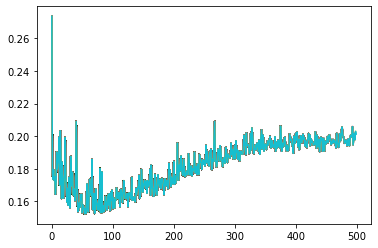

In [6]:
if __name__ == '__main__':
    torch.manual_seed(3)
    src_adj = pd.read_csv('./src_data/'+src_city+'_adj.csv').values
    src_adj = src_adj[:400, :400]
    src_adj = normalized_adj(src_adj)
    src_adj = src_adj.to(device)
    
    net = TGCN(src_adj.shape[0], 1, gru_units, seq_len, pre_len).to(device=device)
#     net = net.double()
    net.train()
    optimizer = torch.optim.Adam(net.parameters(),lr=lr)
    loss_criterion = nn.MSELoss()
    
    training_losses = []
    training_rmses = []
    validation_losses = []
    validation_maes = []
    validation_mapes = []
    validation_pred = []
    validation_acc = []
    validation_r2 = []
    validation_var = []
    validation_rmses = []
    viz.line([0.],[0.],env=environ,win='train_loss',opts=dict(title='train loss'))
    viz.line([0.],[0.],env=environ,win='val_loss',opts=dict(title='val loss'))
    viz.line([0.],[0.],env=environ,win='rmses',opts=dict(title='rmses'))
    viz.line([0.],[0.],env=environ,win='maes',opts=dict(title='maes'))
    viz.line([0.],[0.],env=environ,win='mapes',opts=dict(title='mapes'))
    
    
    for epoch in range(epochs):
        epoch_training_loss = []
        epoch_training_rmses = []
        
        
        for i, (seq_speed, pre_speed) in enumerate(train_loader):
            
            # [32,12,400], [32,3,400]
            optimizer.zero_grad()
            X_batch = seq_speed
            y_batch = pre_speed
            
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            X_batch = X_batch.permute(1,0,2)
            h0 = torch.zeros(X_batch.size(1),num_nodes,gru_units).to(device=device)
            
            out = net(src_adj, X_batch, h0)
            loss = tgcn_loss(out, y_batch)
            
            loss.backward()
            optimizer.step()
            
            batch_rmse = mean_squared_error(out.detach().cpu().numpy().reshape(-1, num_nodes),
                                            y_batch.detach().cpu().numpy().reshape(-1, num_nodes))
            batch_rmse = math.sqrt(batch_rmse)
            epoch_training_rmses.append(batch_rmse)
            epoch_training_loss.append(loss.detach().cpu().numpy())
            
        loss = sum(epoch_training_loss) / len(epoch_training_loss)
        rmse = sum(epoch_training_rmses) / len(epoch_training_rmses)
        
        training_losses.append(loss)
        rmse = Normalize(rmse, train_mean, train_std, train_max, train_min, inv_if_norm)
        training_rmses.append(rmse)
        viz.line([training_losses[-1]],[epoch],env=environ,win='train_loss', update='append')
        
        with torch.no_grad():
            net.eval().to(device)
            tgt_adj = pd.read_csv('./src_data/'+tgt_city+'_adj.csv').values
            tgt_adj = tgt_adj[:400, :400]
            tgt_adj = normalized_adj(tgt_adj)
            tgt_adj = tgt_adj.to(device)
            for i, (val_seq, val_pre) in enumerate(val_loader):
                val_input = val_seq.to(device=device)
                val_target = val_pre.to(device=device)
                
                val_input = val_input.permute(1,0,2)
                h0 = torch.zeros(val_input.size(1),num_nodes,gru_units).to(device=device)
                
                pred = net(tgt_adj, val_input, h0)
                val_loss = tgcn_loss(pred, val_target)
                
                validation_losses.append(np.asscalar(val_loss.detach().cpu().numpy()))
                
                pred_cpu = pred.detach().cpu().numpy().reshape(-1, num_nodes)
                target_cpu = val_target.detach().cpu().numpy().reshape(-1, num_nodes)
                
                pred_cpu = Normalize(pred_cpu, val_mean, val_std, val_max, val_min, inv_if_norm)
                target_cpu = Normalize(target_cpu, val_mean, val_std, val_max, val_min, inv_if_norm)
                
                rmse, mae, mape, acc, r2_score, var_score = evaluation(target_cpu, pred_cpu)
                
                validation_rmses.append(rmse)
                validation_maes.append(mae)
                validation_mapes.append(mape)
                validation_acc.append(var_score)
                validation_r2.append(r2_score)
                validation_var.append(var_score)
                
                
                viz.line([validation_losses[-1]],[epoch],env=environ,win='val_loss', update='append')
                viz.line([rmse],[epoch],env=environ,win='rmses', update='append')
                viz.line([mae],[epoch],env=environ,win='maes', update='append')
                viz.line([mape],[epoch],env=environ,win='mapes', update='append')
#                 fig, axes = plt.subplots()
#                 axes.plot(np.arange(epoch+1), validation_rmses)
#                 axes.plot(np.arange(epoch+1), validation_maes)
#                 axes.legend(['rmses', 'maes','mapes'])
#                 plt.show()
                
                plt.plot(np.arange(epoch+1), validation_mapes)
            
                validation_label = target_cpu
                
                validation_pred.append(pred_cpu)
                
                out = None
                val_input = val_input
                val_target = val_target
                
        print('epoch: '+str(epoch))
        print("Training loss: "+str(training_losses[-1]))
        print("Training rmse: "+str(training_rmses[-1]))
        print("Validation loss: "+str(validation_losses[-1]))
        print("Validation rmse: "+str(validation_rmses[-1]))
        print("Validation mae: "+str(validation_maes[-1]))
        print("Validation mape: "+str(validation_mapes[-1]))
        print("Validation acc: "+str(validation_acc[-1]))
        if (epoch%1000==0):
            if os.path.exists('./epoch')==False:
                os.makedirs('./epoch')
            torch.save(net, './epoch/model_epoch'+str(epoch)+'.pk1')
    
    index = validation_rmses.index(np.min(validation_rmses))
    test_result = validation_pred[index]
    var = pd.DataFrame(test_result)
    var.to_csv('./epoch/test_epoch'+str(index)+'.csv',index=False, header=False)
    np.savez('sh_L_loss', Train_loss=training_losses, Train_rmse=training_rmses, Val_loss=validation_losses, Val_rmse=validation_rmses, Val_mae=validation_maes, Val_acc=validation_acc)
    print(validation_label.shape)
    print(test_result.shape)
    